In [16]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [17]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)

In [18]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = pz.Binomial(n=1, p=theta_real).rvs(trials)
data

array([1, 0, 0, 0])

In [4]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata = pm.sample(1000, random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


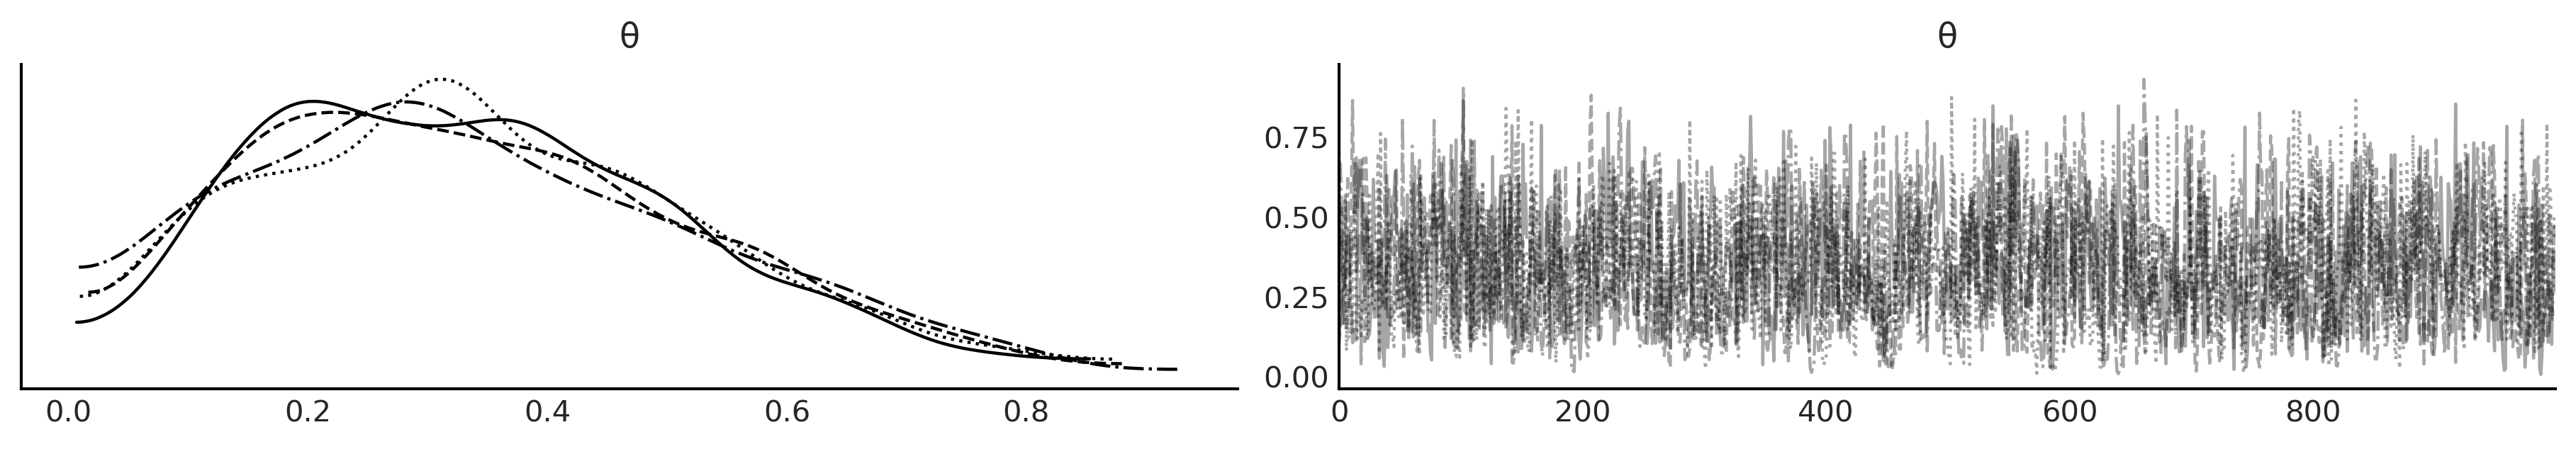

In [5]:
az.plot_trace(idata)
plt.savefig("../fig/idata_trace.png")

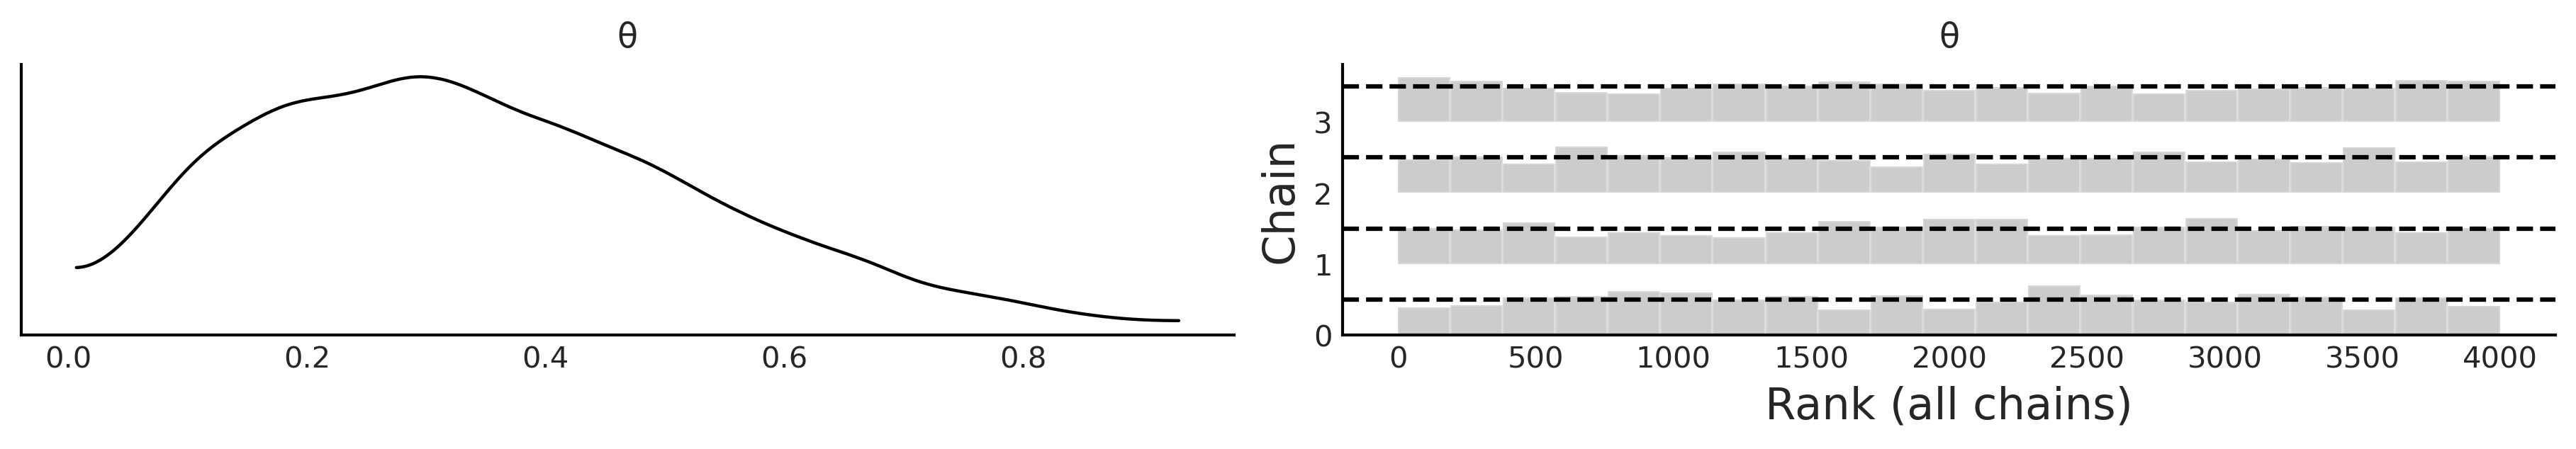

In [6]:
az.plot_trace(idata, kind="rank_bars", combined=True, rank_kwargs={"colors": "k"});
plt.savefig("../fig/idata_rank.png")

In [7]:
az.summary(idata, kind="stats").round(2)

mean    sd  hdi_3%  hdi_97%
θ  0.34  0.18    0.04     0.67

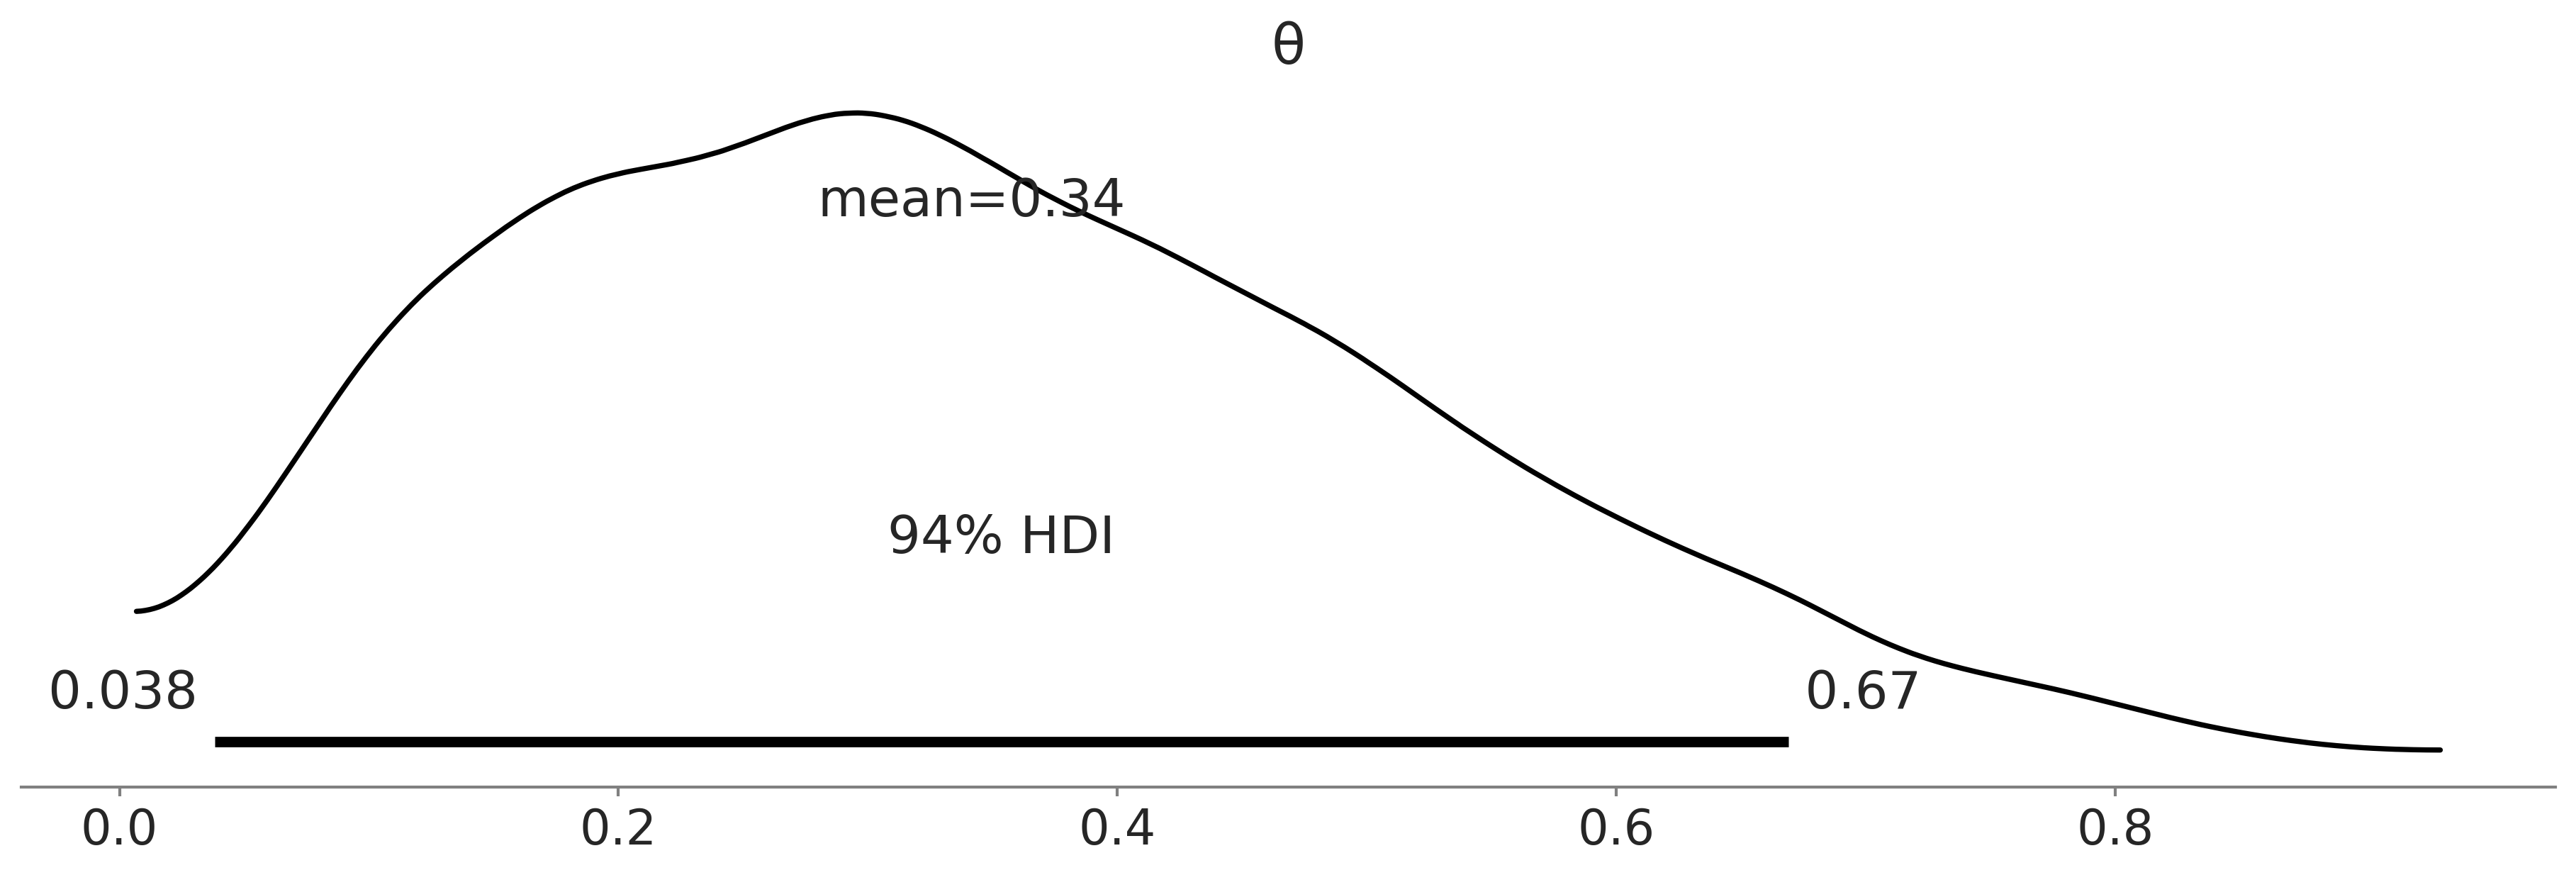

In [8]:
az.plot_posterior(idata, figsize=(12, 4))
plt.savefig("../fig/idata_posterior.png")

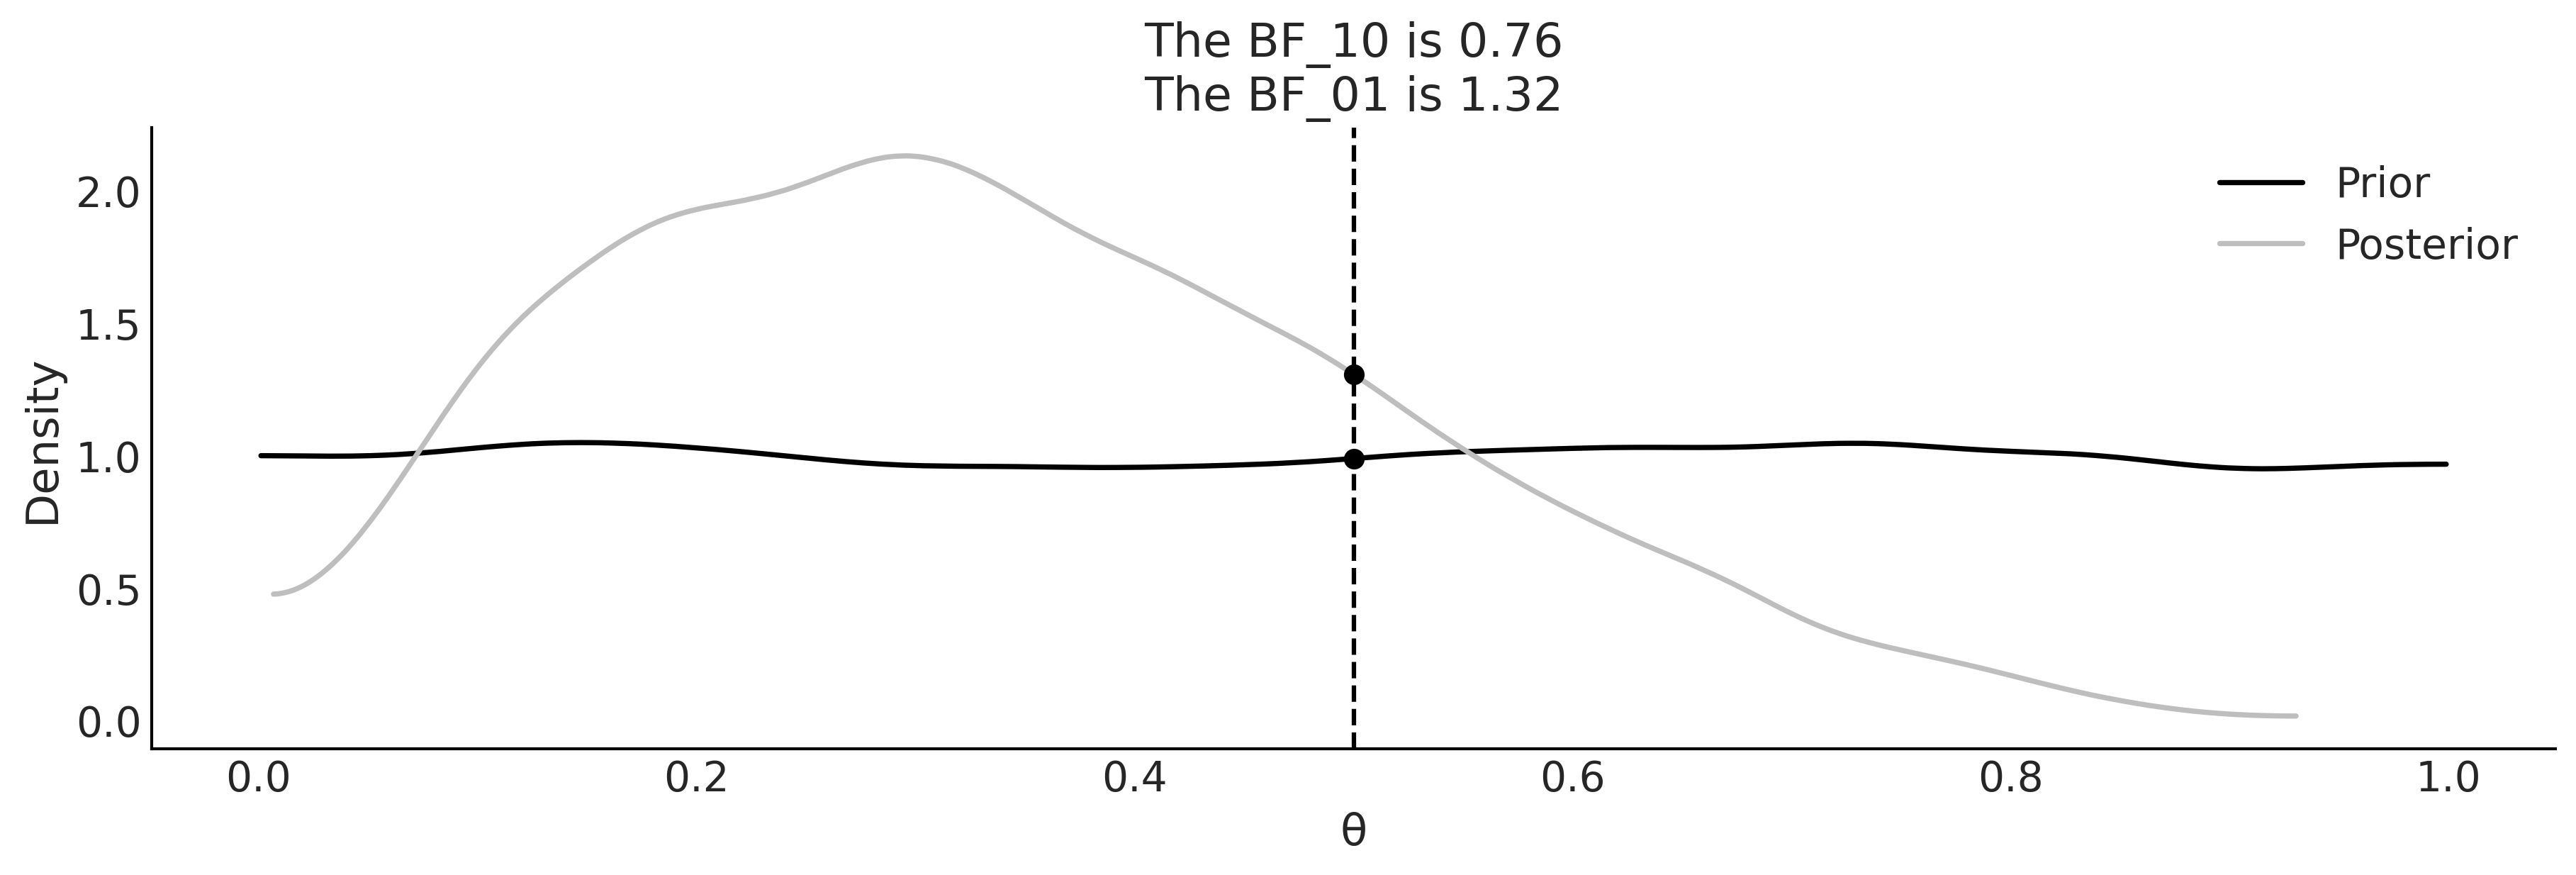

In [9]:
az.plot_bf(idata, var_name="θ", prior=np.random.uniform(0, 1, 10000), ref_val=0.5, figsize=(12, 4), colors=["C0", "C2"])
plt.savefig("../fig/idata_bf.png")

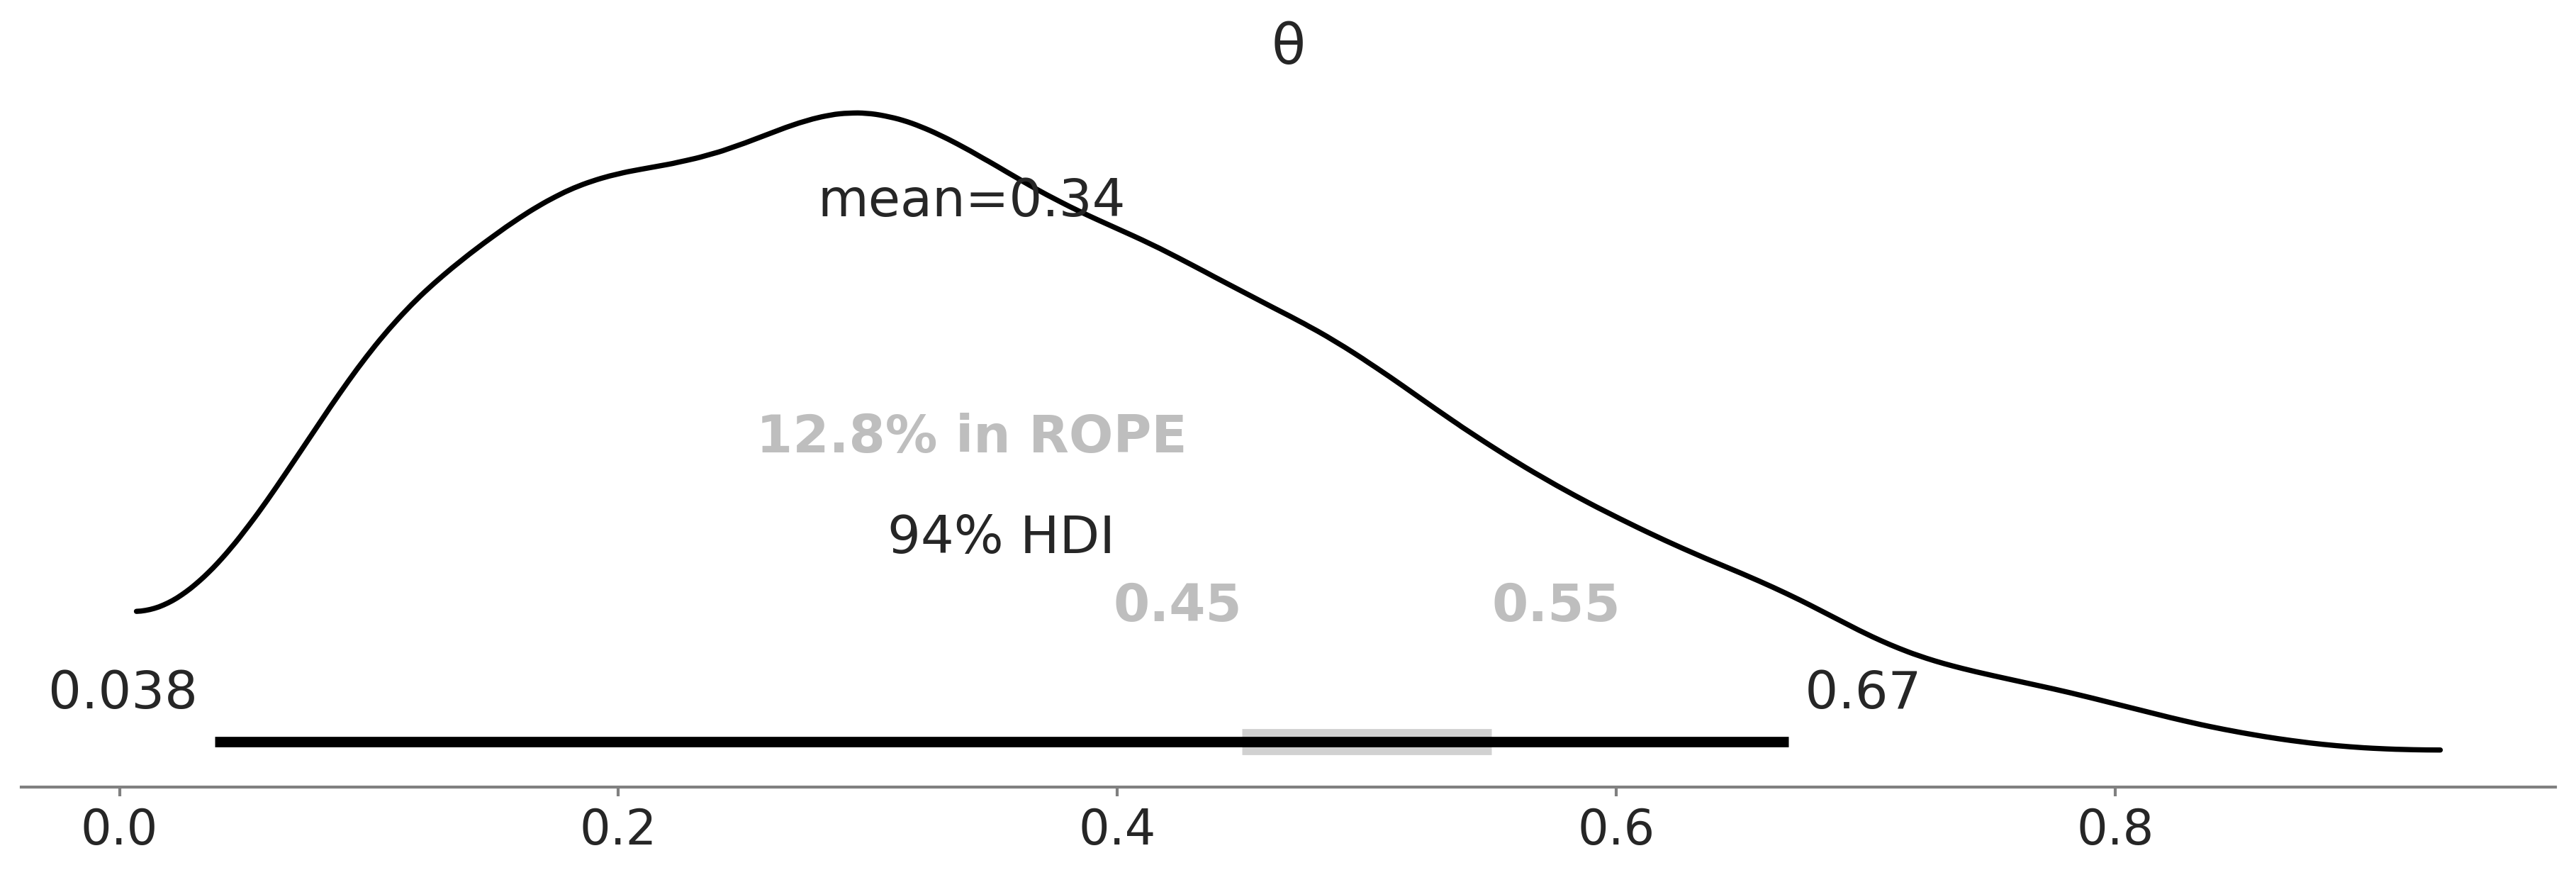

In [10]:
az.plot_posterior(idata, rope=[0.45, .55], figsize=(12, 4))
plt.savefig("../fig/idata_posterior_rope.png")


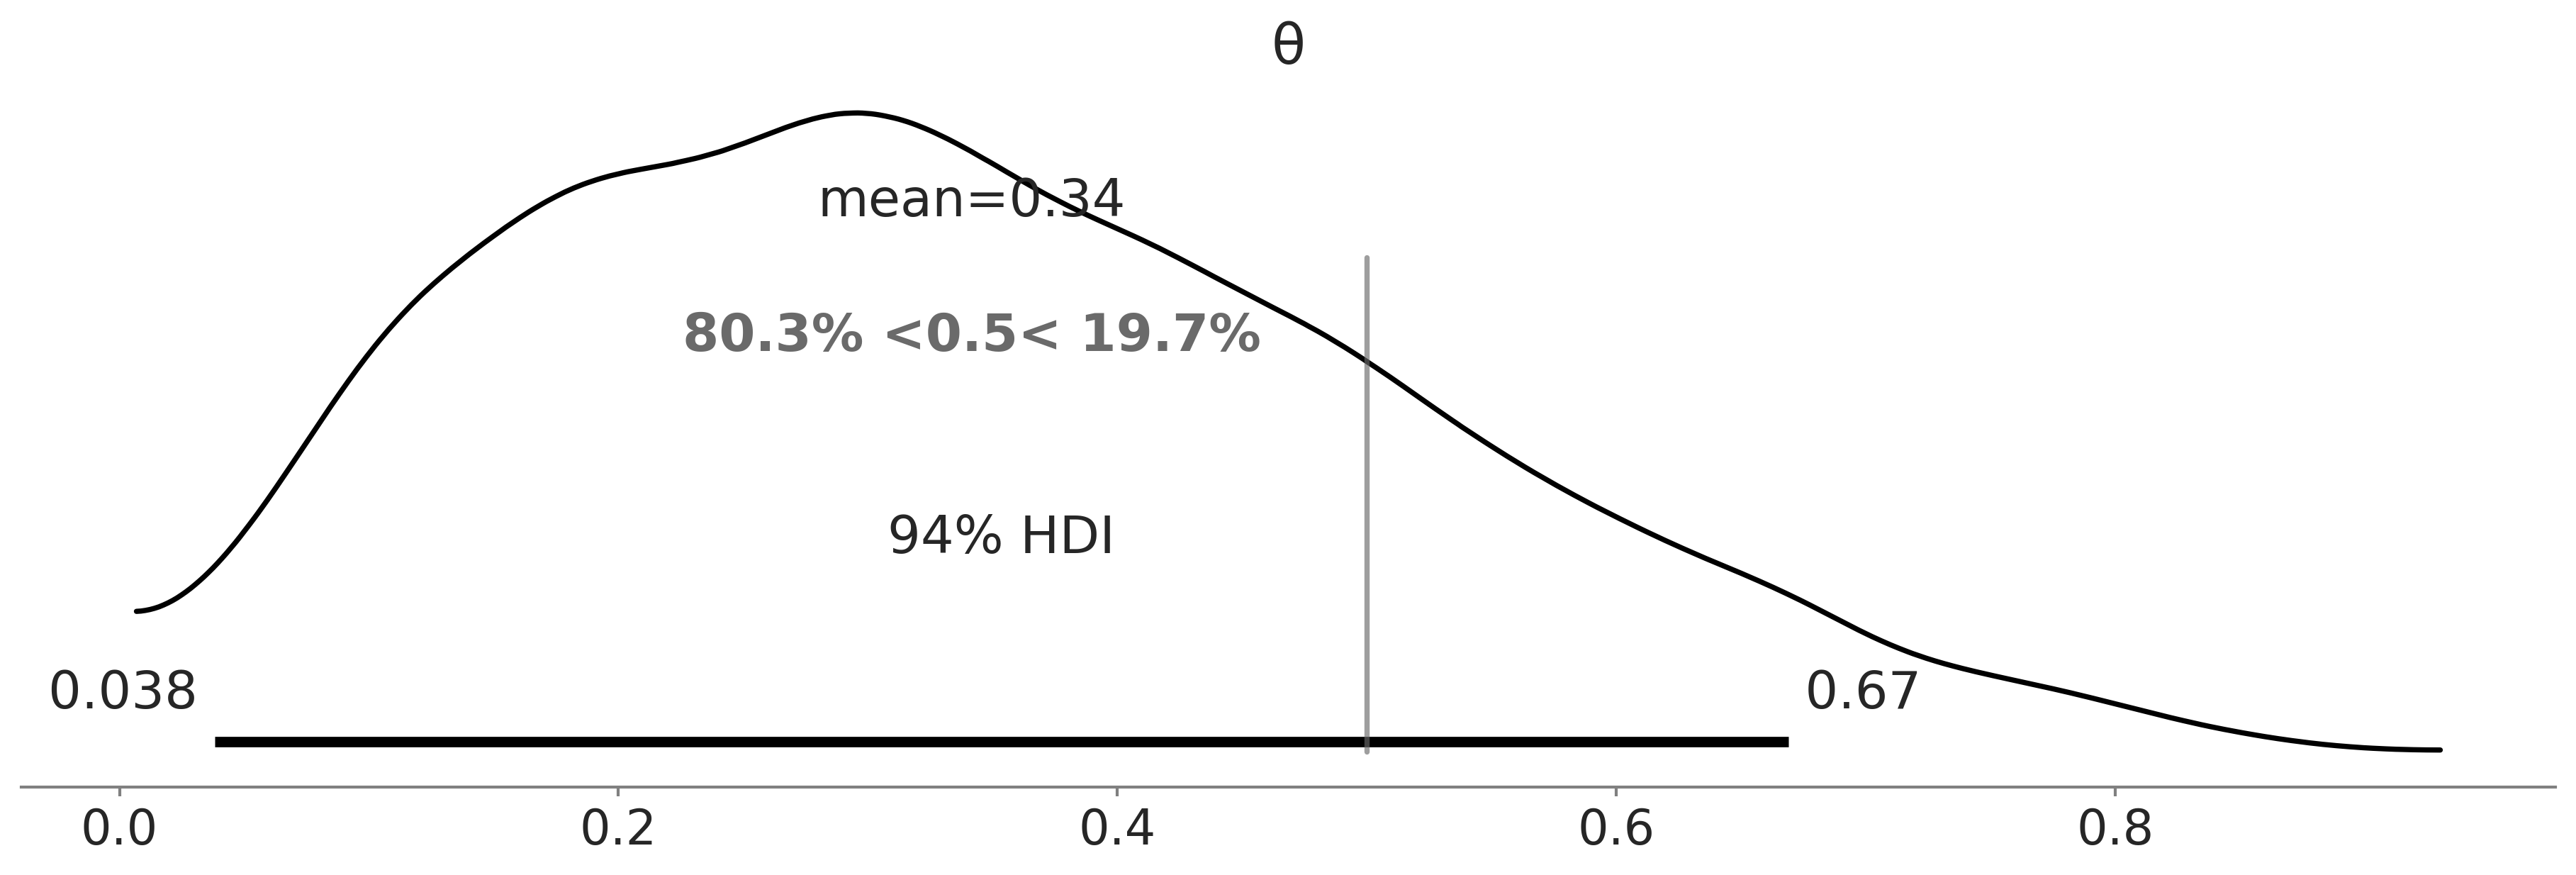

In [11]:
az.plot_posterior(idata, ref_val=0.5, figsize=(12, 4))
plt.savefig("../fig/idata_posterior_ref.png")

In [12]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
np.argmin(lossf_a)

64

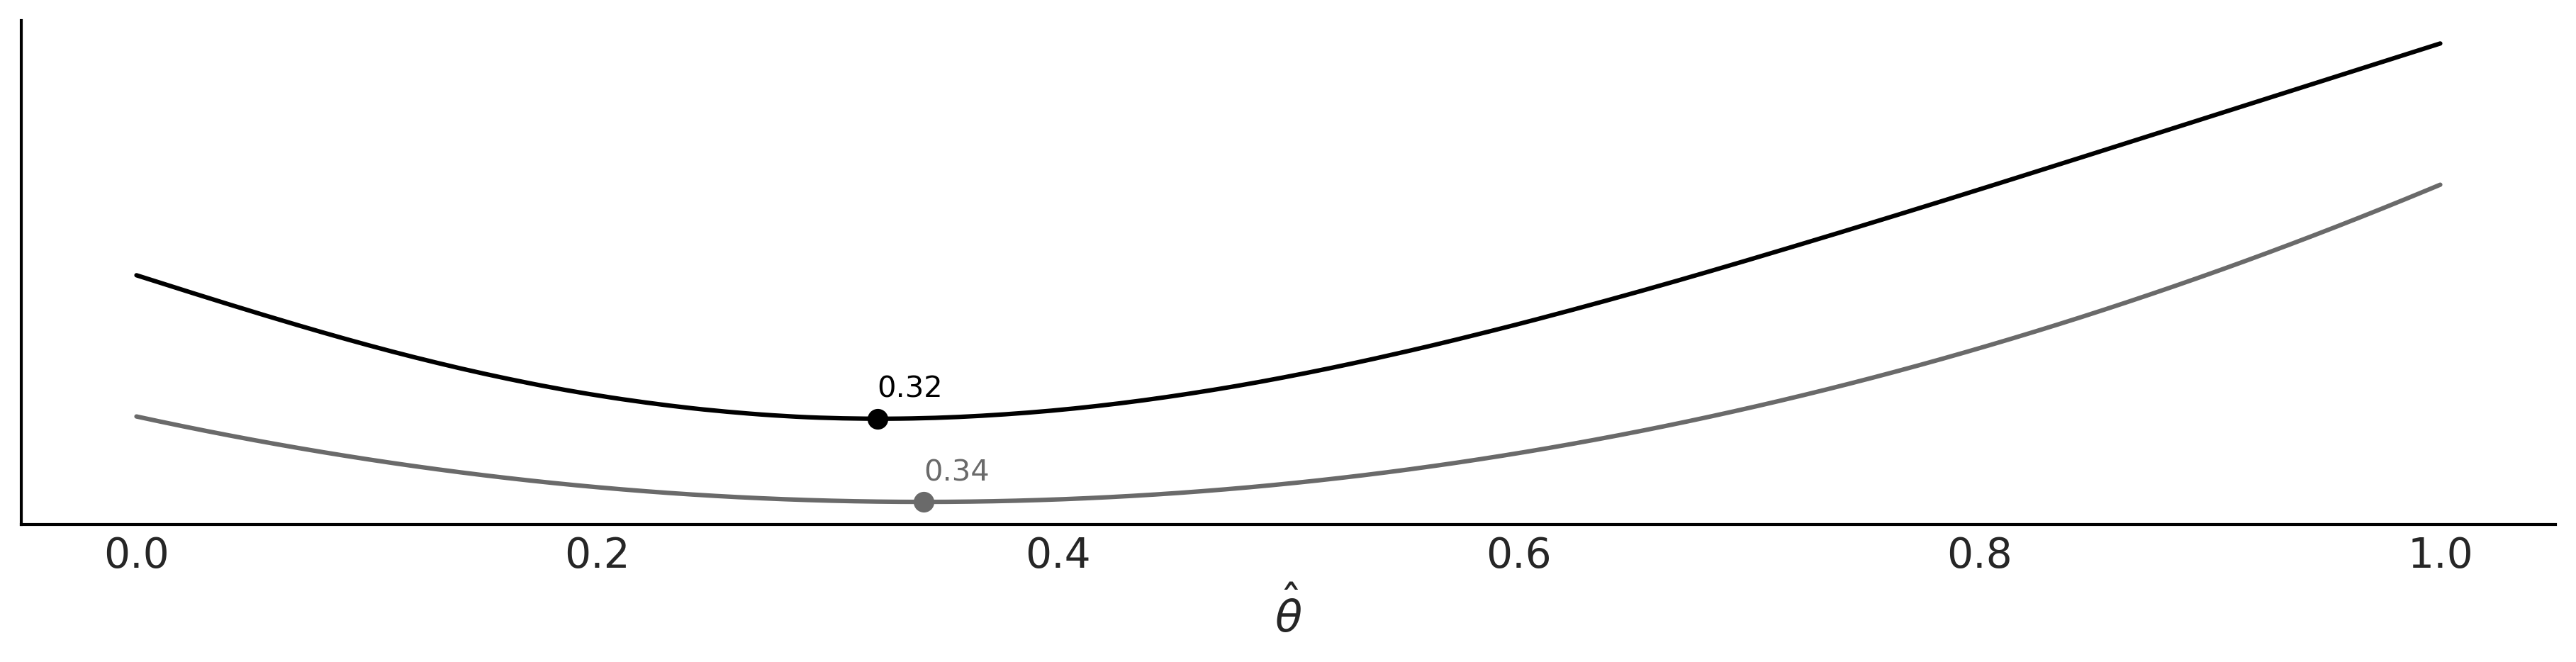

In [13]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
_, ax = plt.subplots(figsize=(12, 3))
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    ax.plot(grid, lossf, c)
    ax.plot(grid[mini], lossf[mini], 'o', color=c)
    ax.annotate('{:.2f}'.format(grid[mini]),
    (grid[mini], lossf[mini] + 0.03), color=c)

    ax.set_yticks([])
    ax.set_xlabel(r'$\hat \theta$')

plt.savefig("../fig/idata_loss.png")

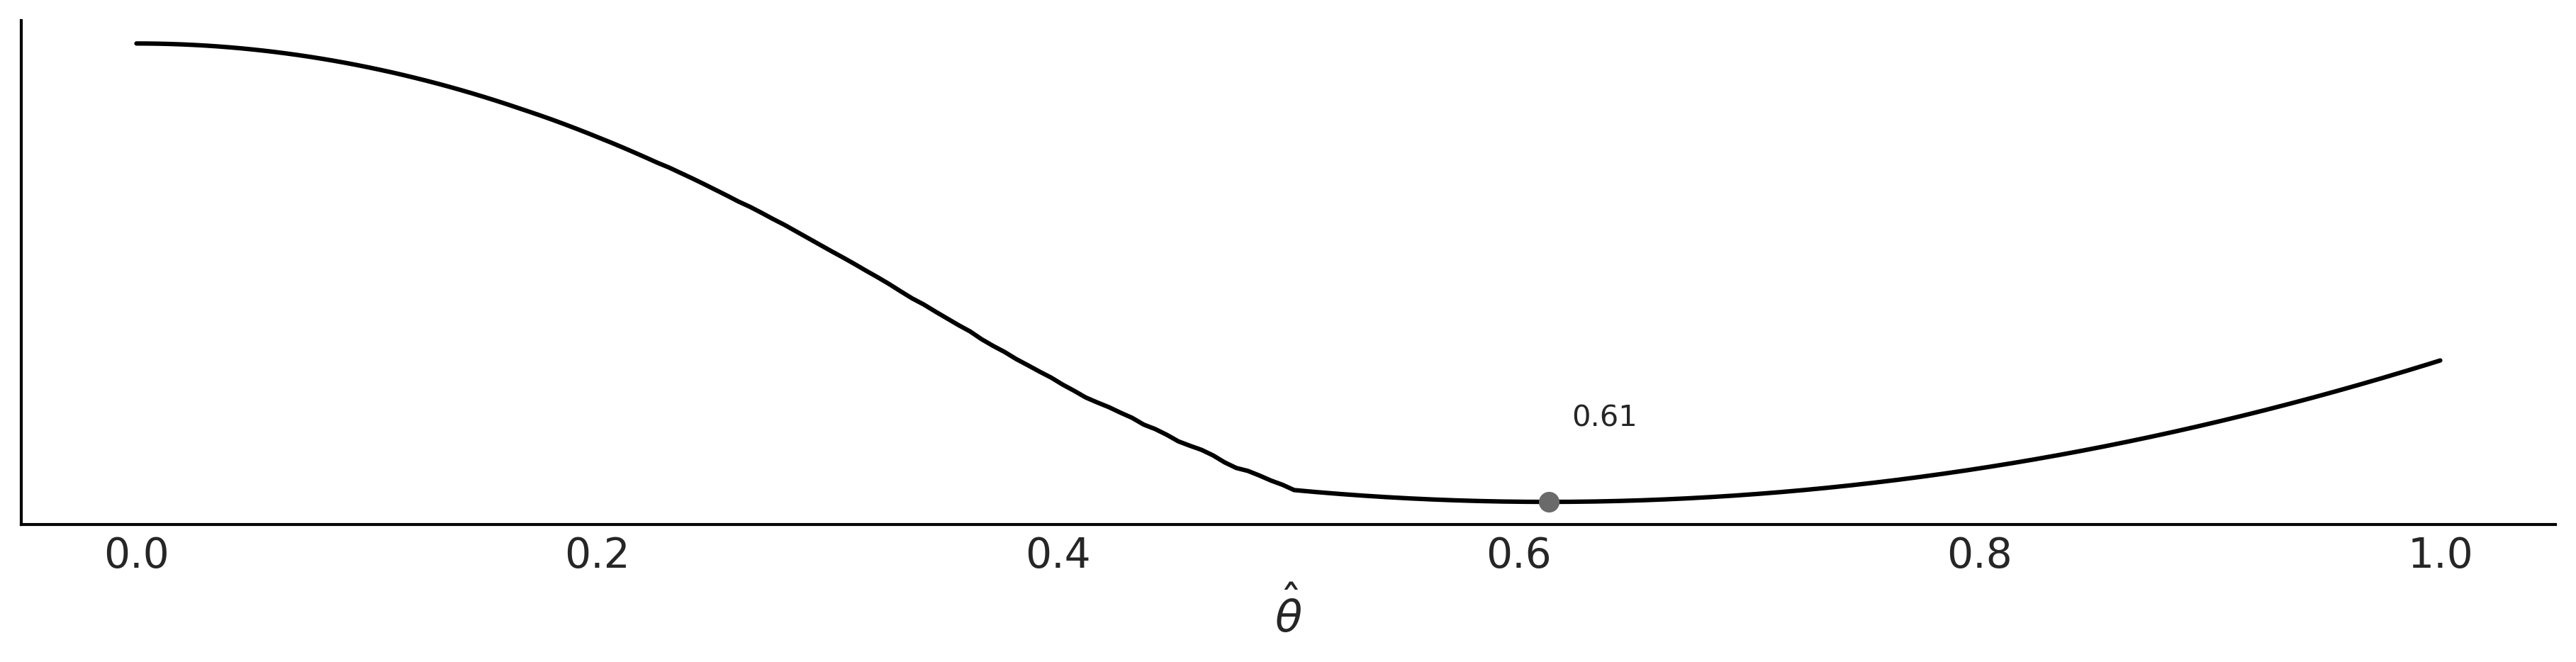

In [14]:
lossf = []
for i in grid:
    if i < 0.5:
        f = 1/np.median(θ_pos / np.abs(i**2 - θ_pos))
    else:
        f = np.mean((i - θ_pos)**2 + np.exp(-i)) - 0.25
    lossf.append(f)
mini = np.argmin(lossf)
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(grid, lossf)
ax.plot(grid[mini], lossf[mini], 'o')
ax.annotate('{:.2f}'.format(grid[mini]),
(grid[mini] + 0.01, lossf[mini] + 0.1))
ax.set_yticks([])
ax.set_xlabel(r'$\hat \theta$')
plt.savefig("../fig/idata_loss2.png")

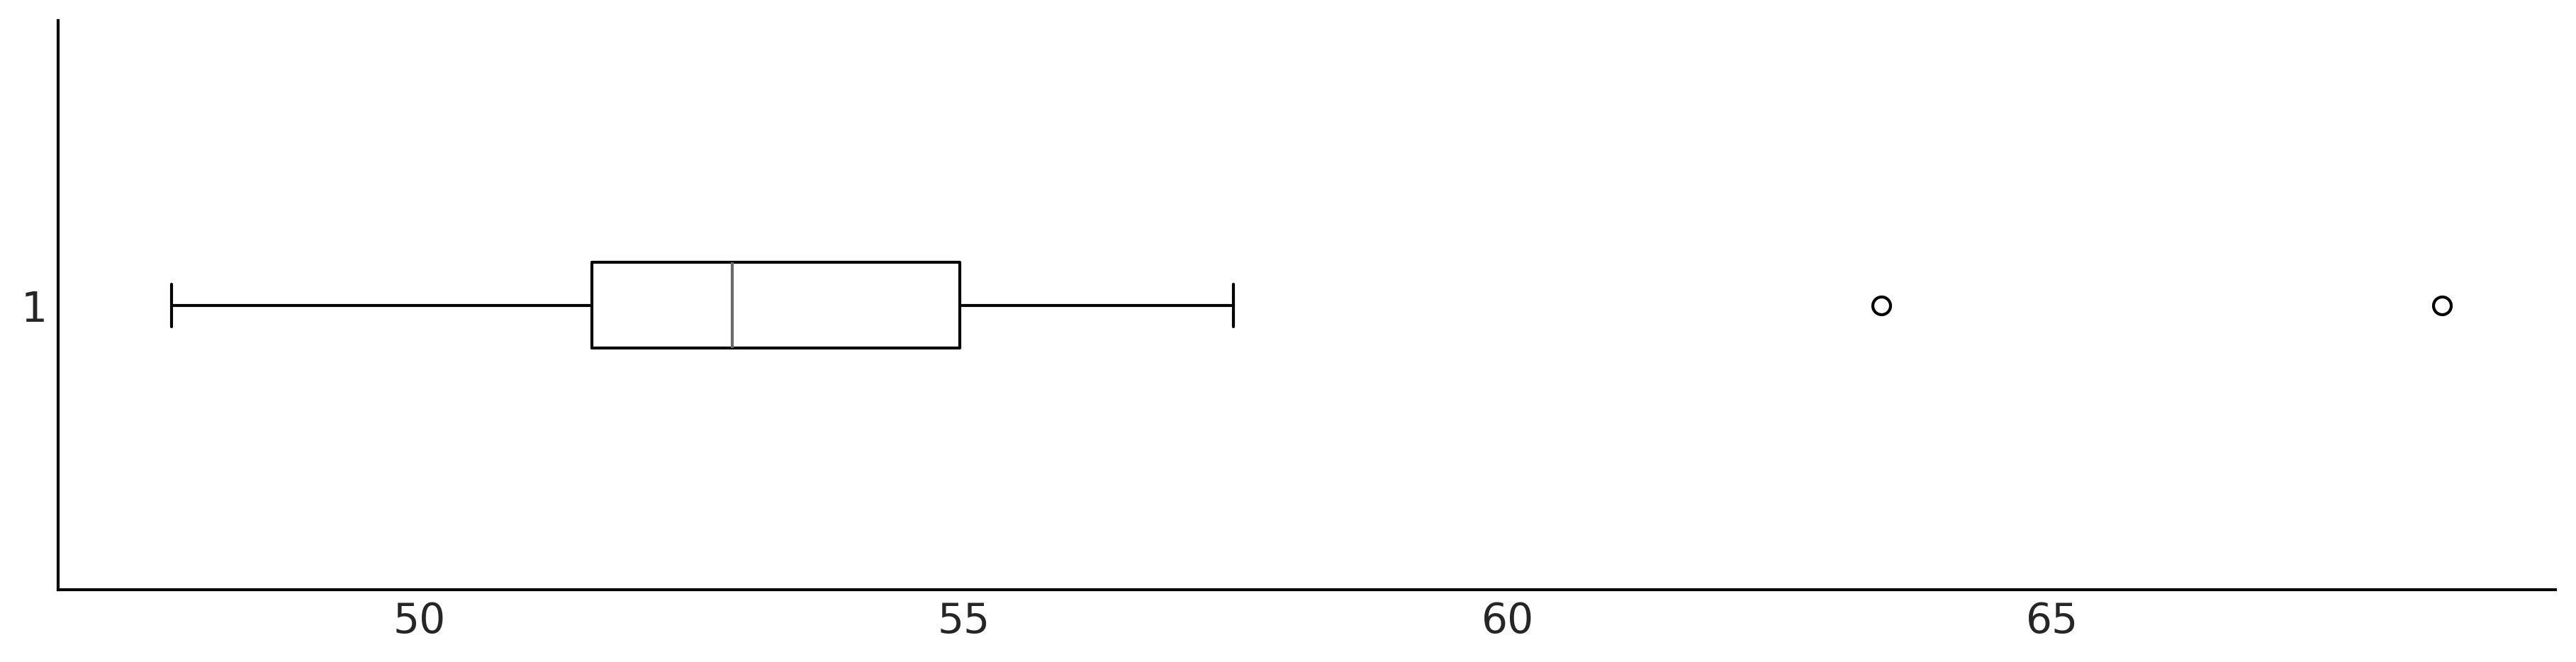

In [19]:
data = np.loadtxt("data/chemical_shifts.csv")
_, ax = plt.subplots(figsize=(12, 3))
ax.boxplot(data, vert=False)
plt.savefig("../fig/boxplot.png")

In [21]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sigma=5)
    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data)
    idata_g = pm.sample(random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


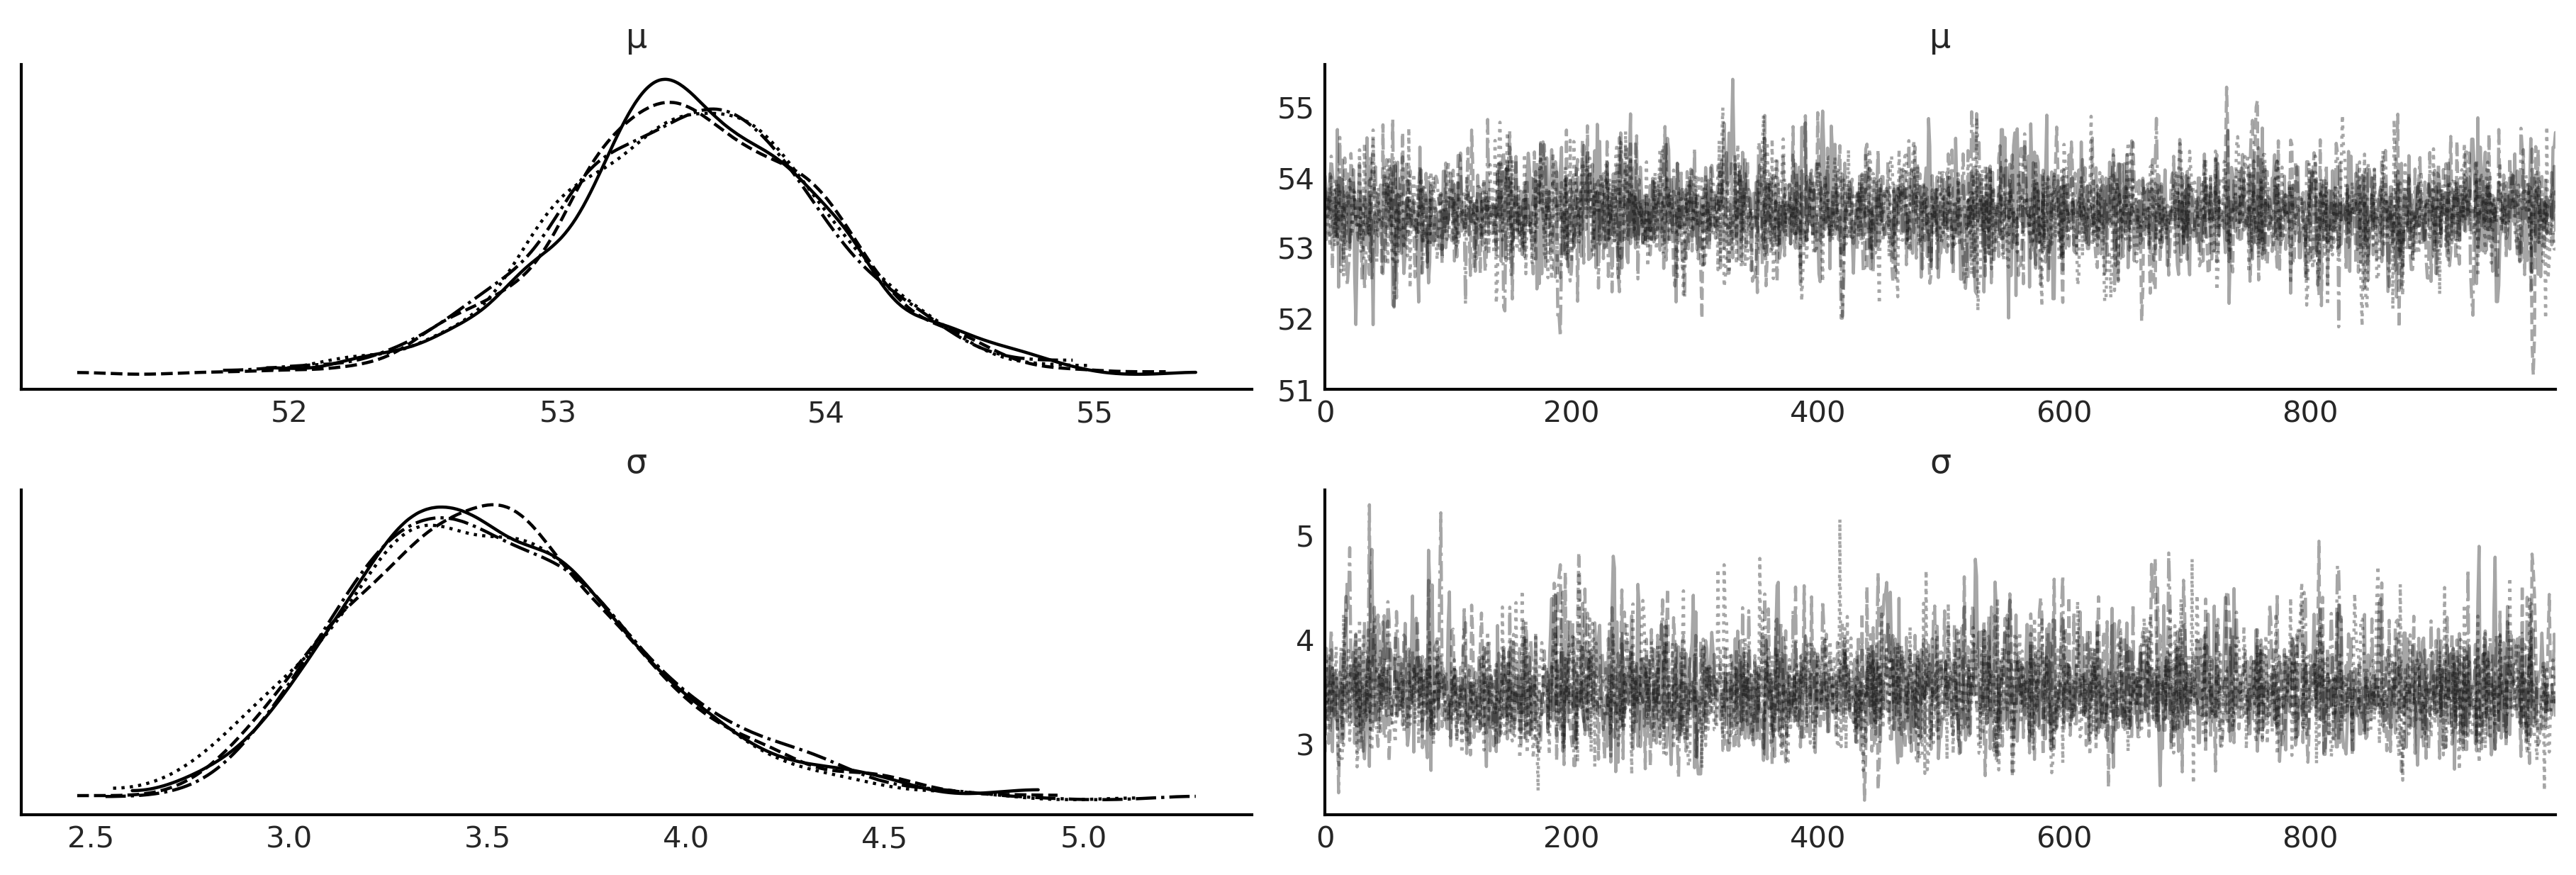

In [22]:
az.plot_trace(idata_g);
plt.savefig("../fig/idata_g_trace.png")

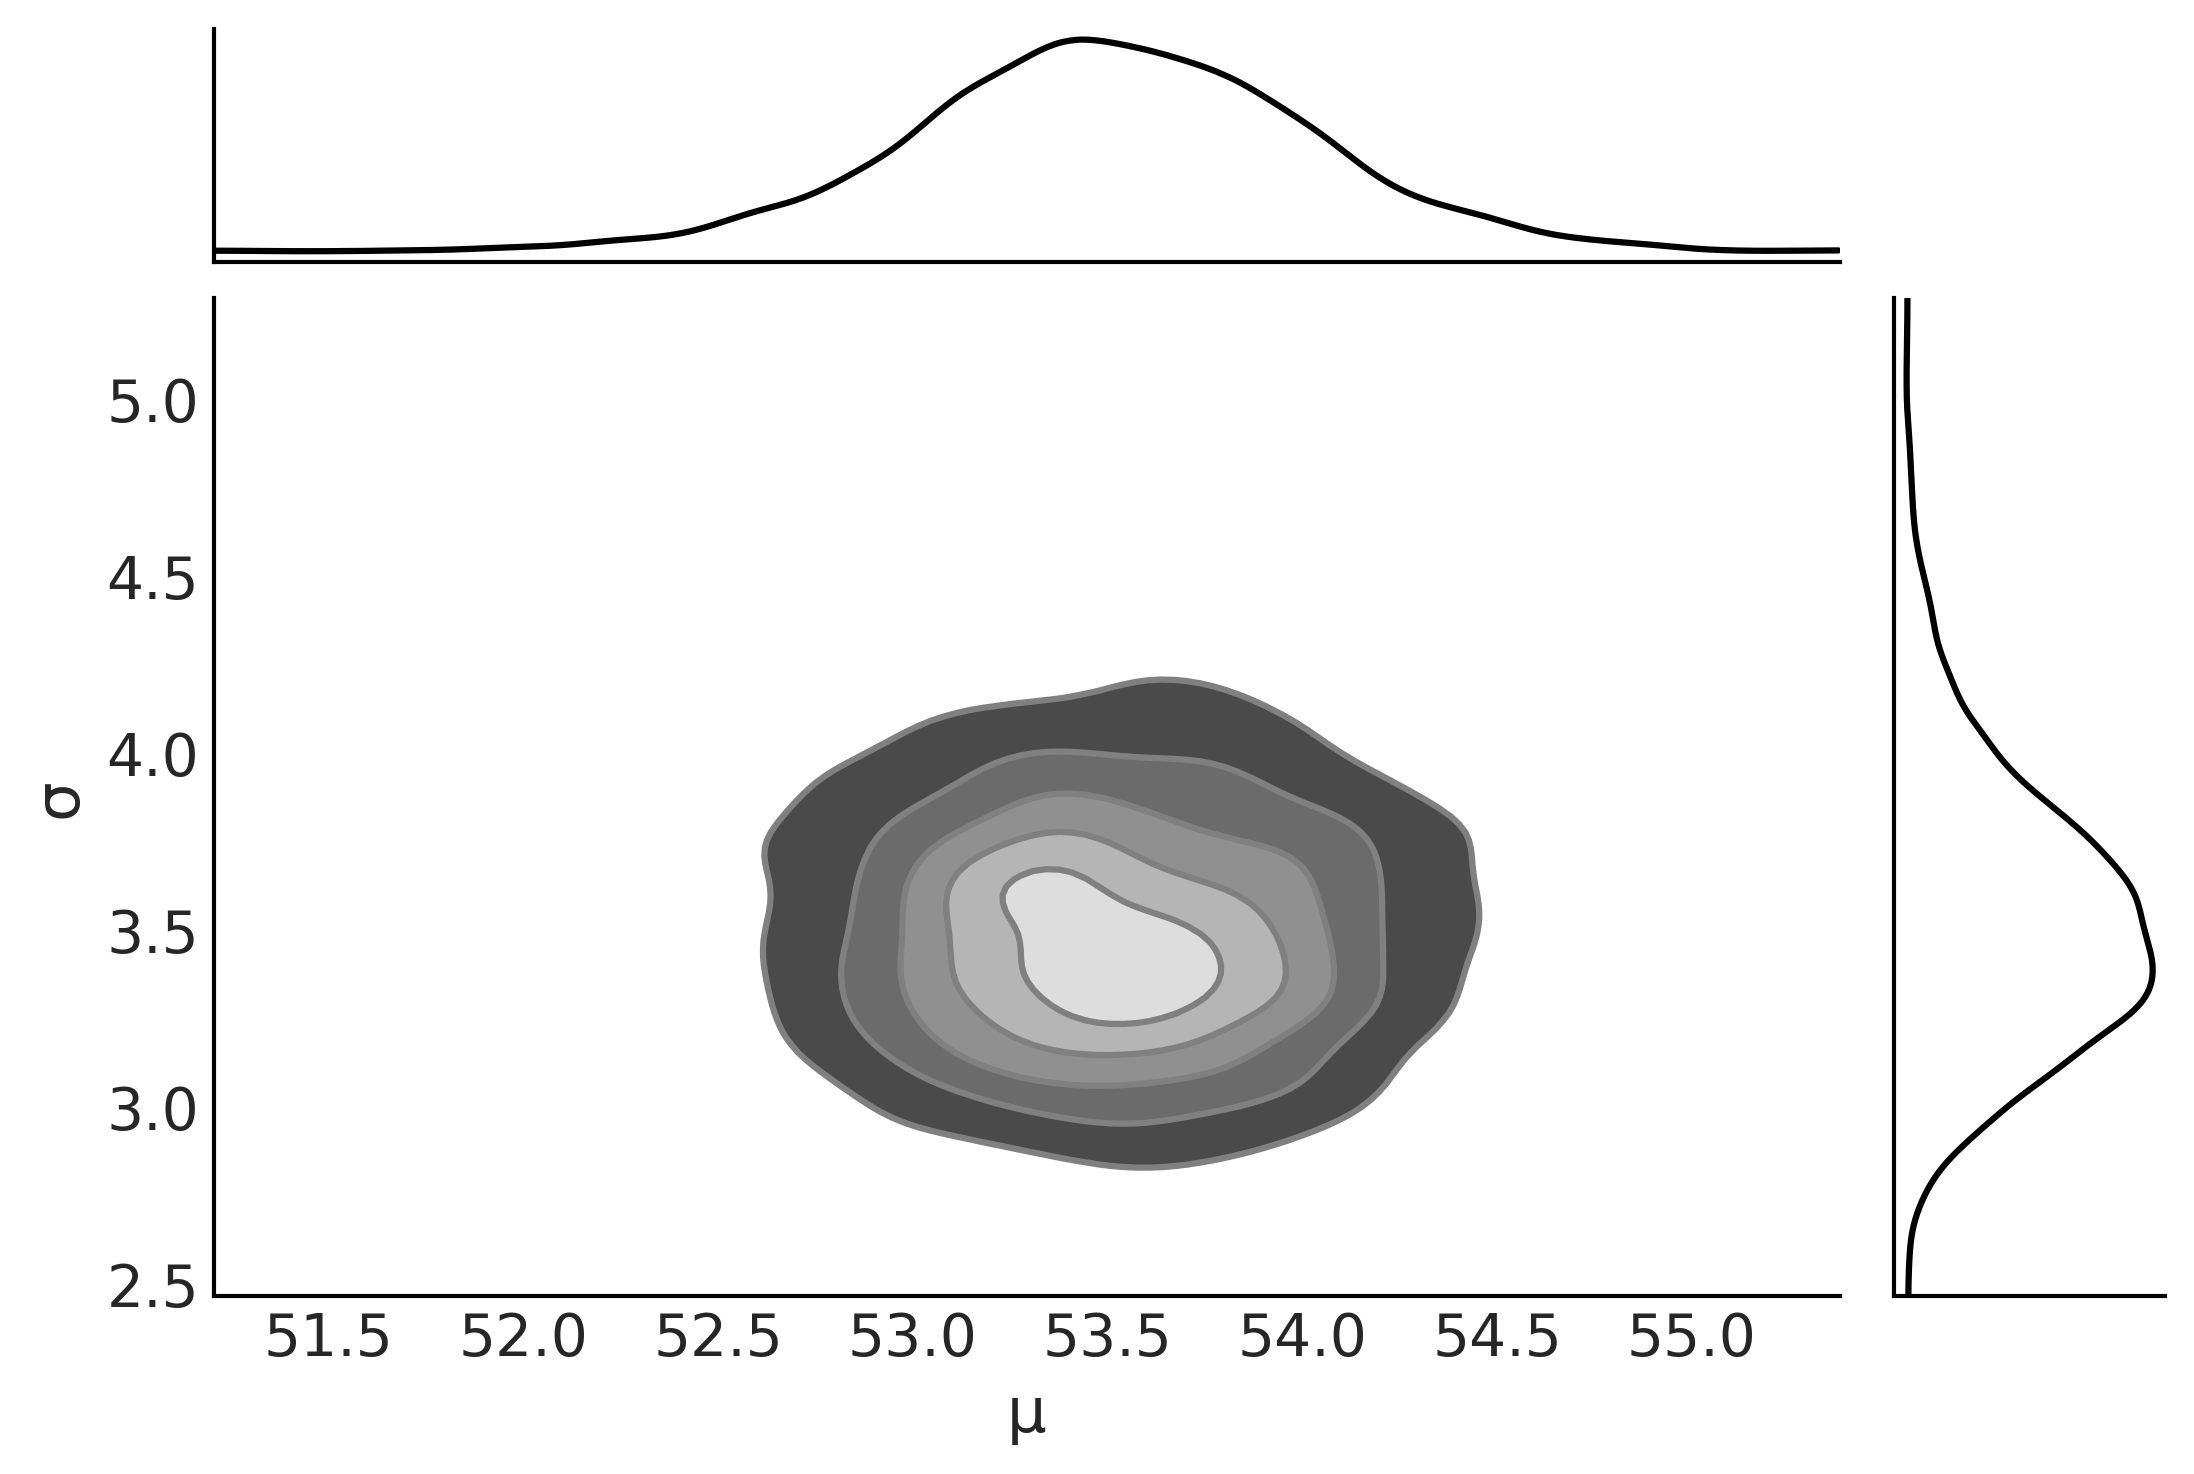

In [23]:
az.plot_pair(idata_g, kind='kde', marginals=True)
plt.savefig("../fig/idata_g_pair.png")

In [24]:
az.summary(idata_g, kind="stats").round(2)

mean    sd  hdi_3%  hdi_97%
μ  53.50  0.50   52.52    54.43
σ   3.52  0.38    2.86     4.25

In [25]:
pm.sample_posterior_predictive(idata_g, model=model_g, extend_inferencedata=True, random_seed=4591)


Sampling: [Y]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

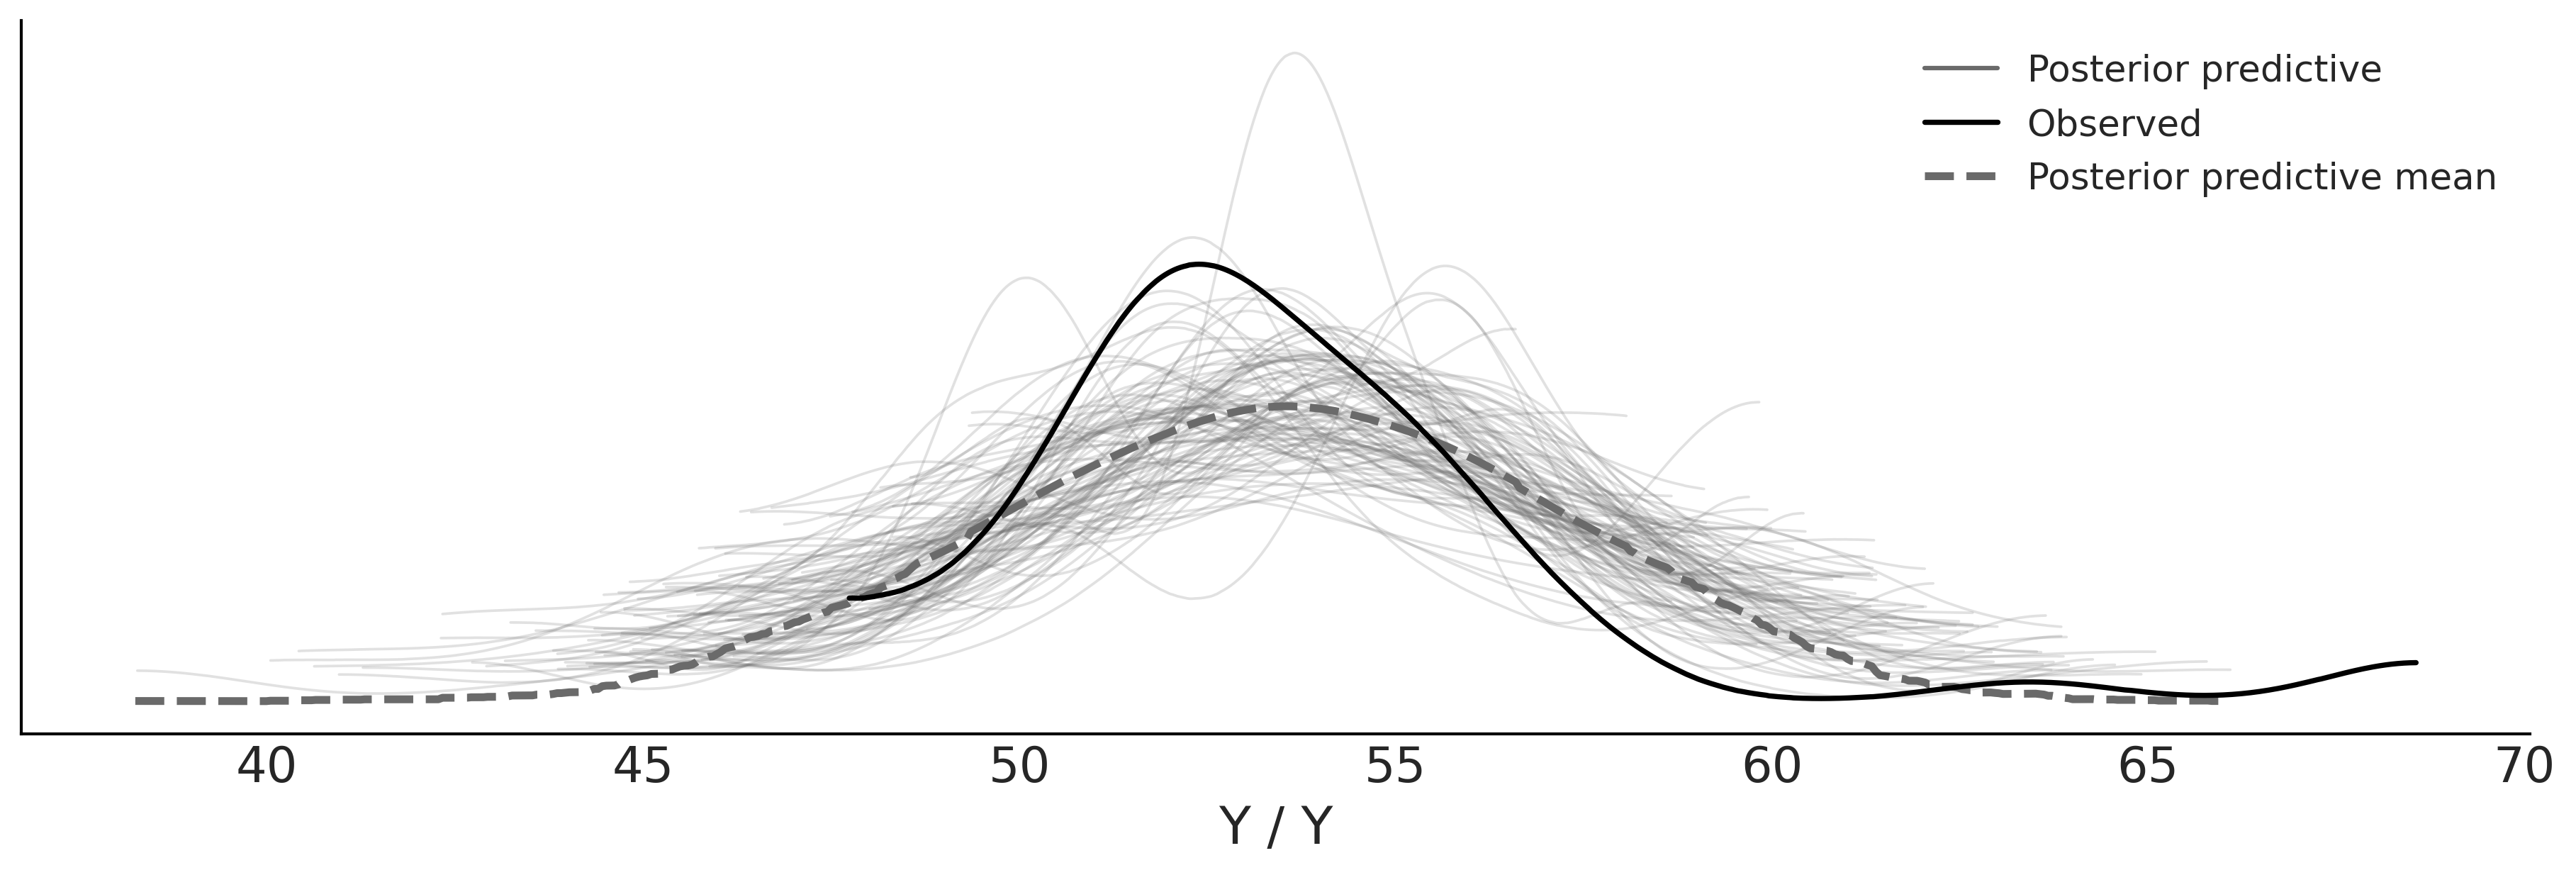

In [26]:
az.plot_ppc(idata_g, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plt.savefig("../fig/idata_g_ppc.png")

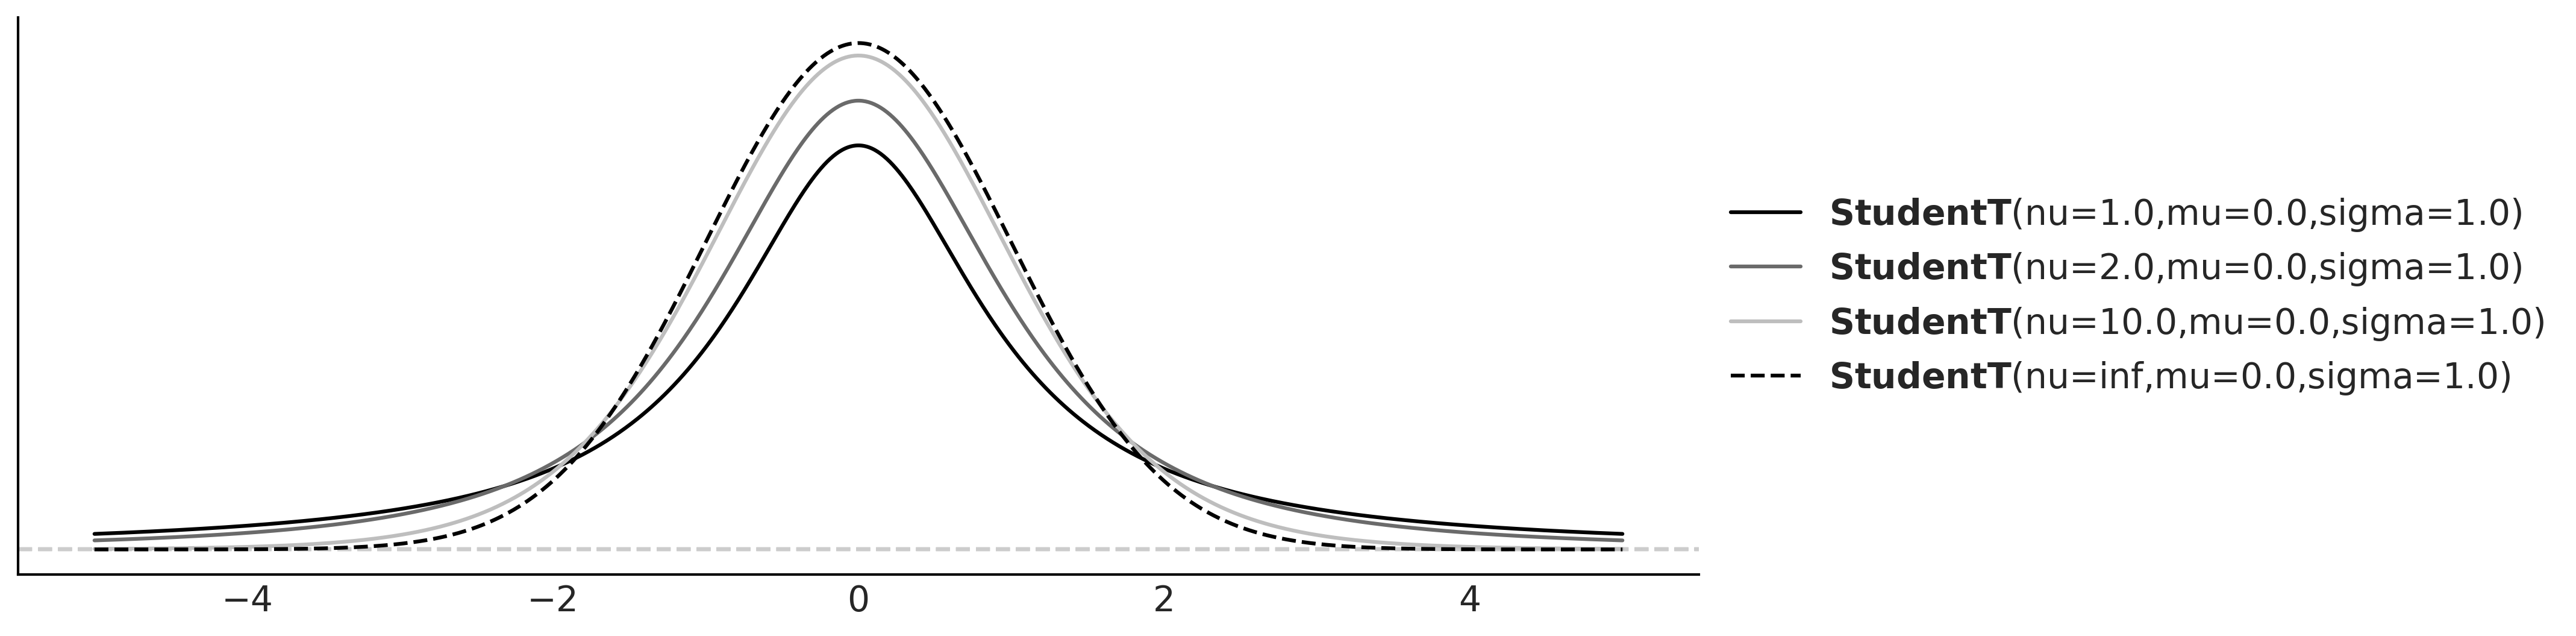

In [41]:
for nu in [1, 2, 10]:
    pz.StudentT(nu, 0, 1).plot_pdf(support=(-5, 5), figsize=(12, 4))

ax = pz.StudentT(np.inf, 0, 1).plot_pdf(support=(-5, 5), figsize=(12, 4), color="k")
ax.get_lines()[-1].set_linestyle("--")
pz.internal.plot_helper.side_legend(ax)
plt.savefig("../fig/student_t.png")

In [23]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sigma=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', nu=ν, mu=μ, sigma=σ, observed=data)
    idata_t = pm.sample(random_seed=4591)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


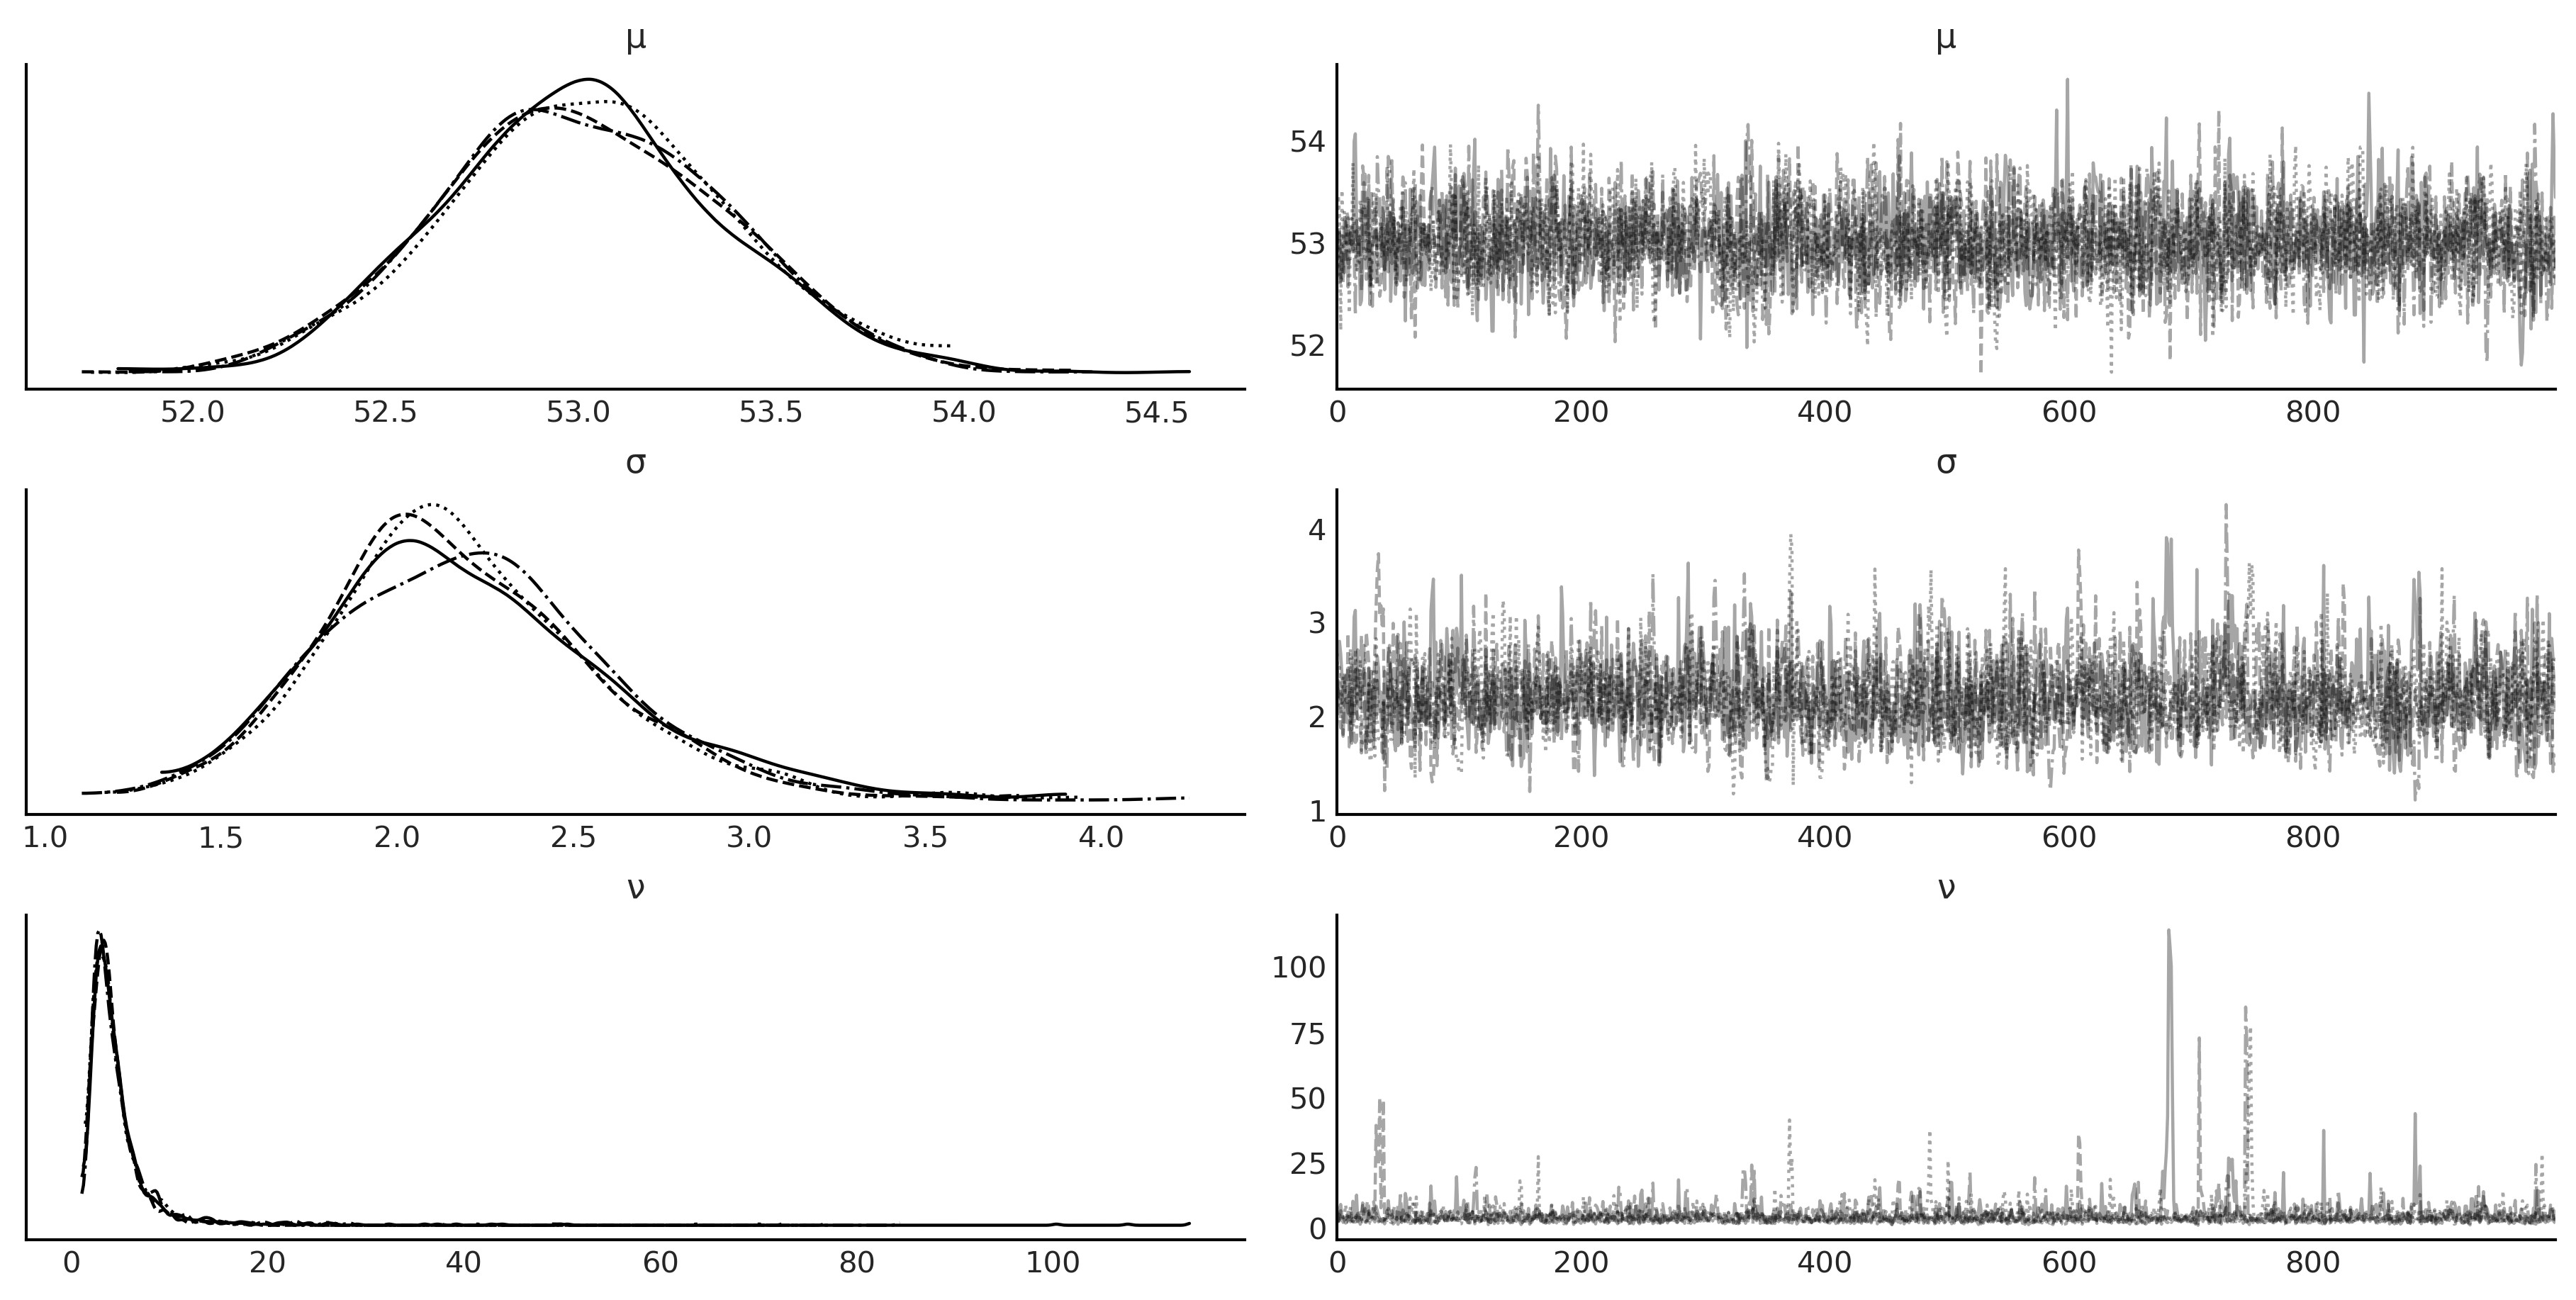

In [24]:
az.plot_trace(idata_t)
plt.savefig("../fig/idata_t_trace.png")

In [25]:
az.summary(idata_t, kind="stats", round_to=2)

mean    sd  hdi_3%  hdi_97%
μ  53.01  0.37   52.30    53.68
σ   2.19  0.40    1.49     2.97
ν   4.72  5.18    1.24     9.28

Sampling: [y]


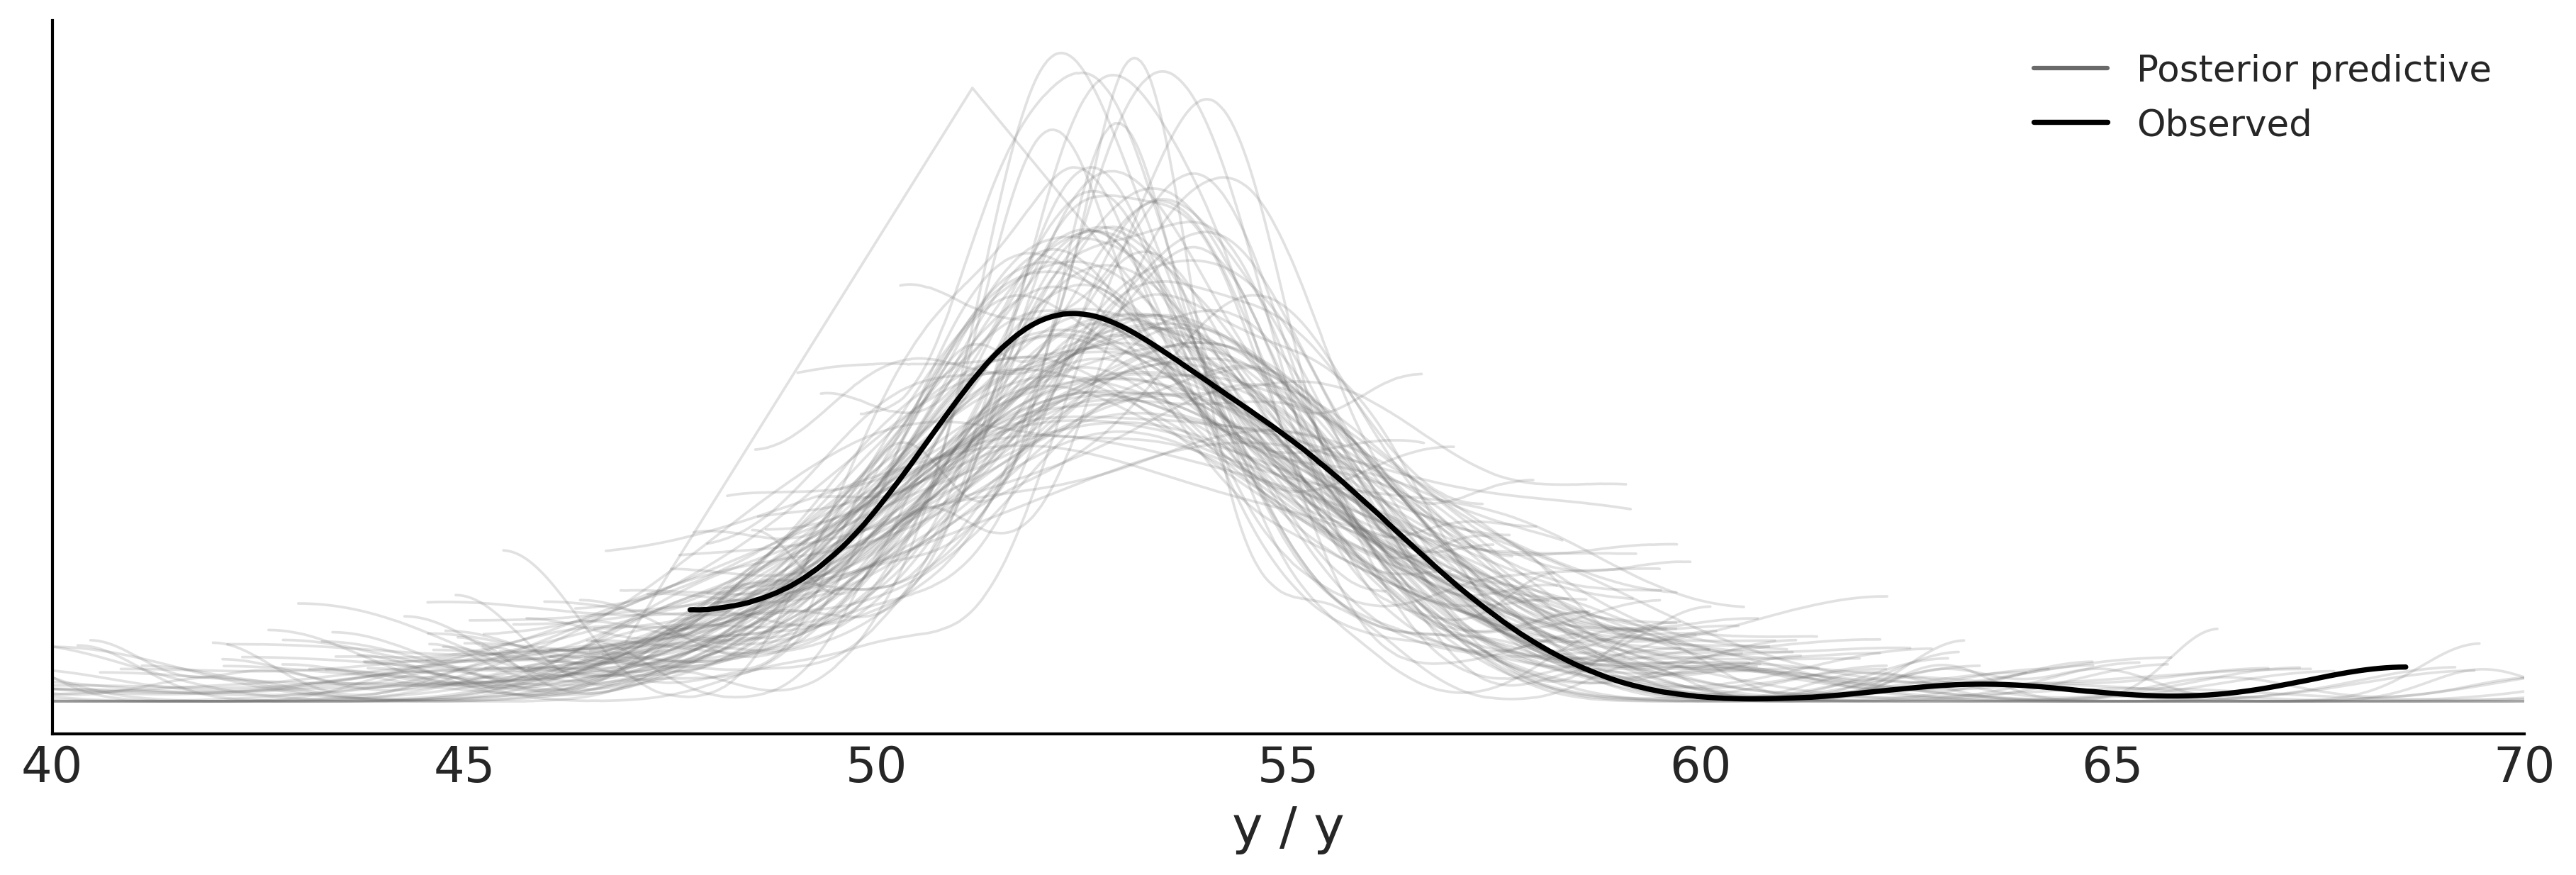

In [26]:
pm.sample_posterior_predictive(idata_t, model=model_t, extend_inferencedata=True, random_seed=123)
ax= az.plot_ppc(idata_t, figsize=(12, 4), num_pp_samples=100, mean=False, colors=["C1", "C0", "C1"])
ax.set_xlim(40, 70)
plt.savefig("../fig/idata_t_ppc.png")

In [27]:
idata_g

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [28]:
posterior = idata_g.posterior

In [29]:
posterior.sel(draw=0, chain=[0, 2])

<xarray.Dataset>
Dimensions:  (chain: 2)
Coordinates:
  * chain    (chain) int64 0 2
    draw     int64 0
Data variables:
    μ        (chain) float64 54.01 53.85
    σ        (chain) float64 3.481 2.924
Attributes:
    created_at:                 2023-12-09T14:32:48.876412
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              1.4730088710784912
    tuning_steps:               1000

In [30]:
posterior.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ        float64 53.5
    σ        float64 3.525

In [31]:
posterior.mean("draw")

<xarray.Dataset>
Dimensions:  (chain: 4)
Coordinates:
  * chain    (chain) int64 0 1 2 3
Data variables:
    μ        (chain) float64 53.52 53.5 53.5 53.49
    σ        (chain) float64 3.527 3.504 3.527 3.542

In [32]:
stacked = az.extract(idata_g)

## Comparaing groups

In [33]:
tips = pd.read_csv("data/tips.csv")
tips.tail()

total_bill   tip     sex smoker   day    time  size
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

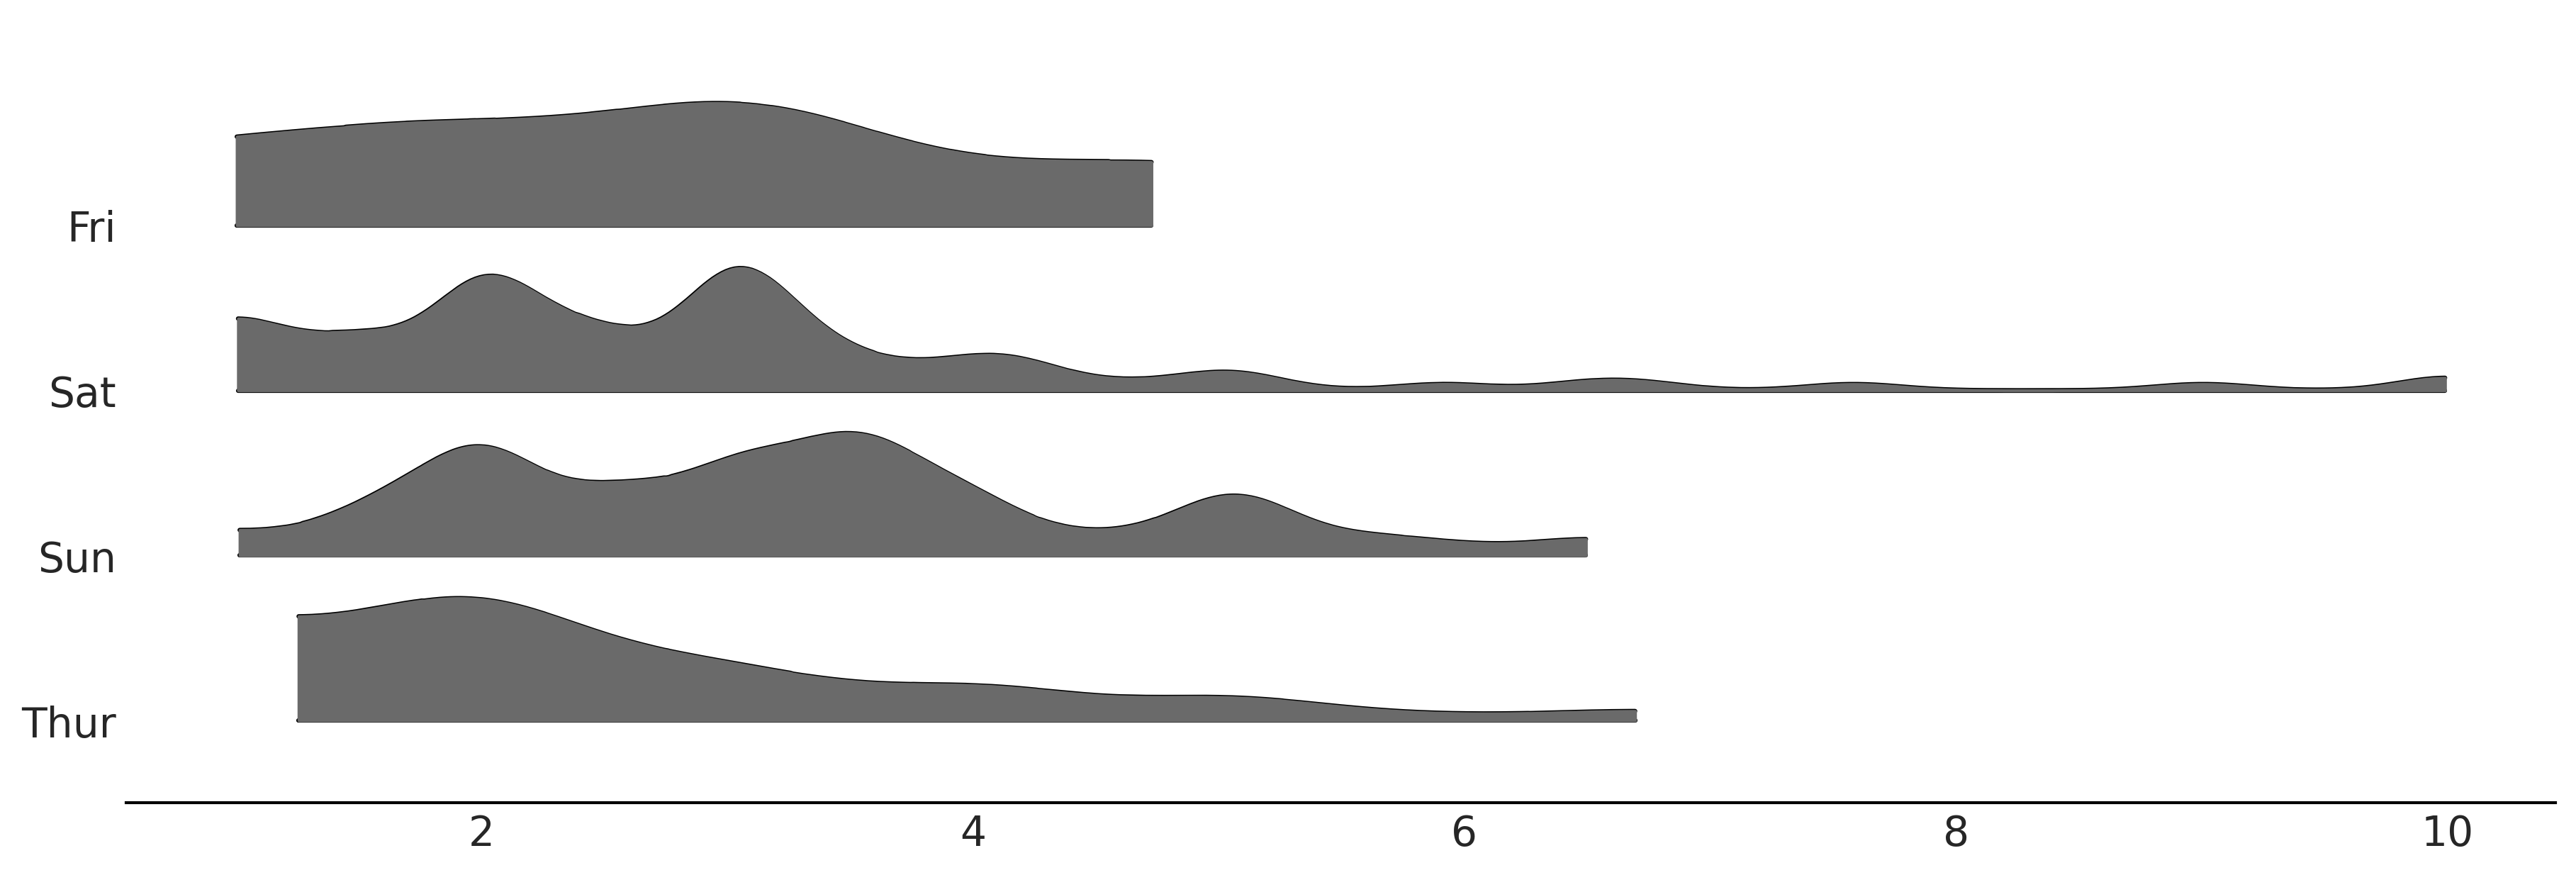

In [34]:
az.plot_forest(tips.pivot(columns="day", values="tip").to_dict("list"),
               kind="ridgeplot",
               hdi_prob=1,
               colors="C1",
               figsize=(12, 4))
plt.savefig("../fig/tips_ridgeplot.png")

In [35]:
categories = np.array(["Thur", "Fri", "Sat", "Sun"])

tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

In [36]:
coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal("μ", sigma=5, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg = pm.sample(random_seed=4591)
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg, random_seed=4591))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


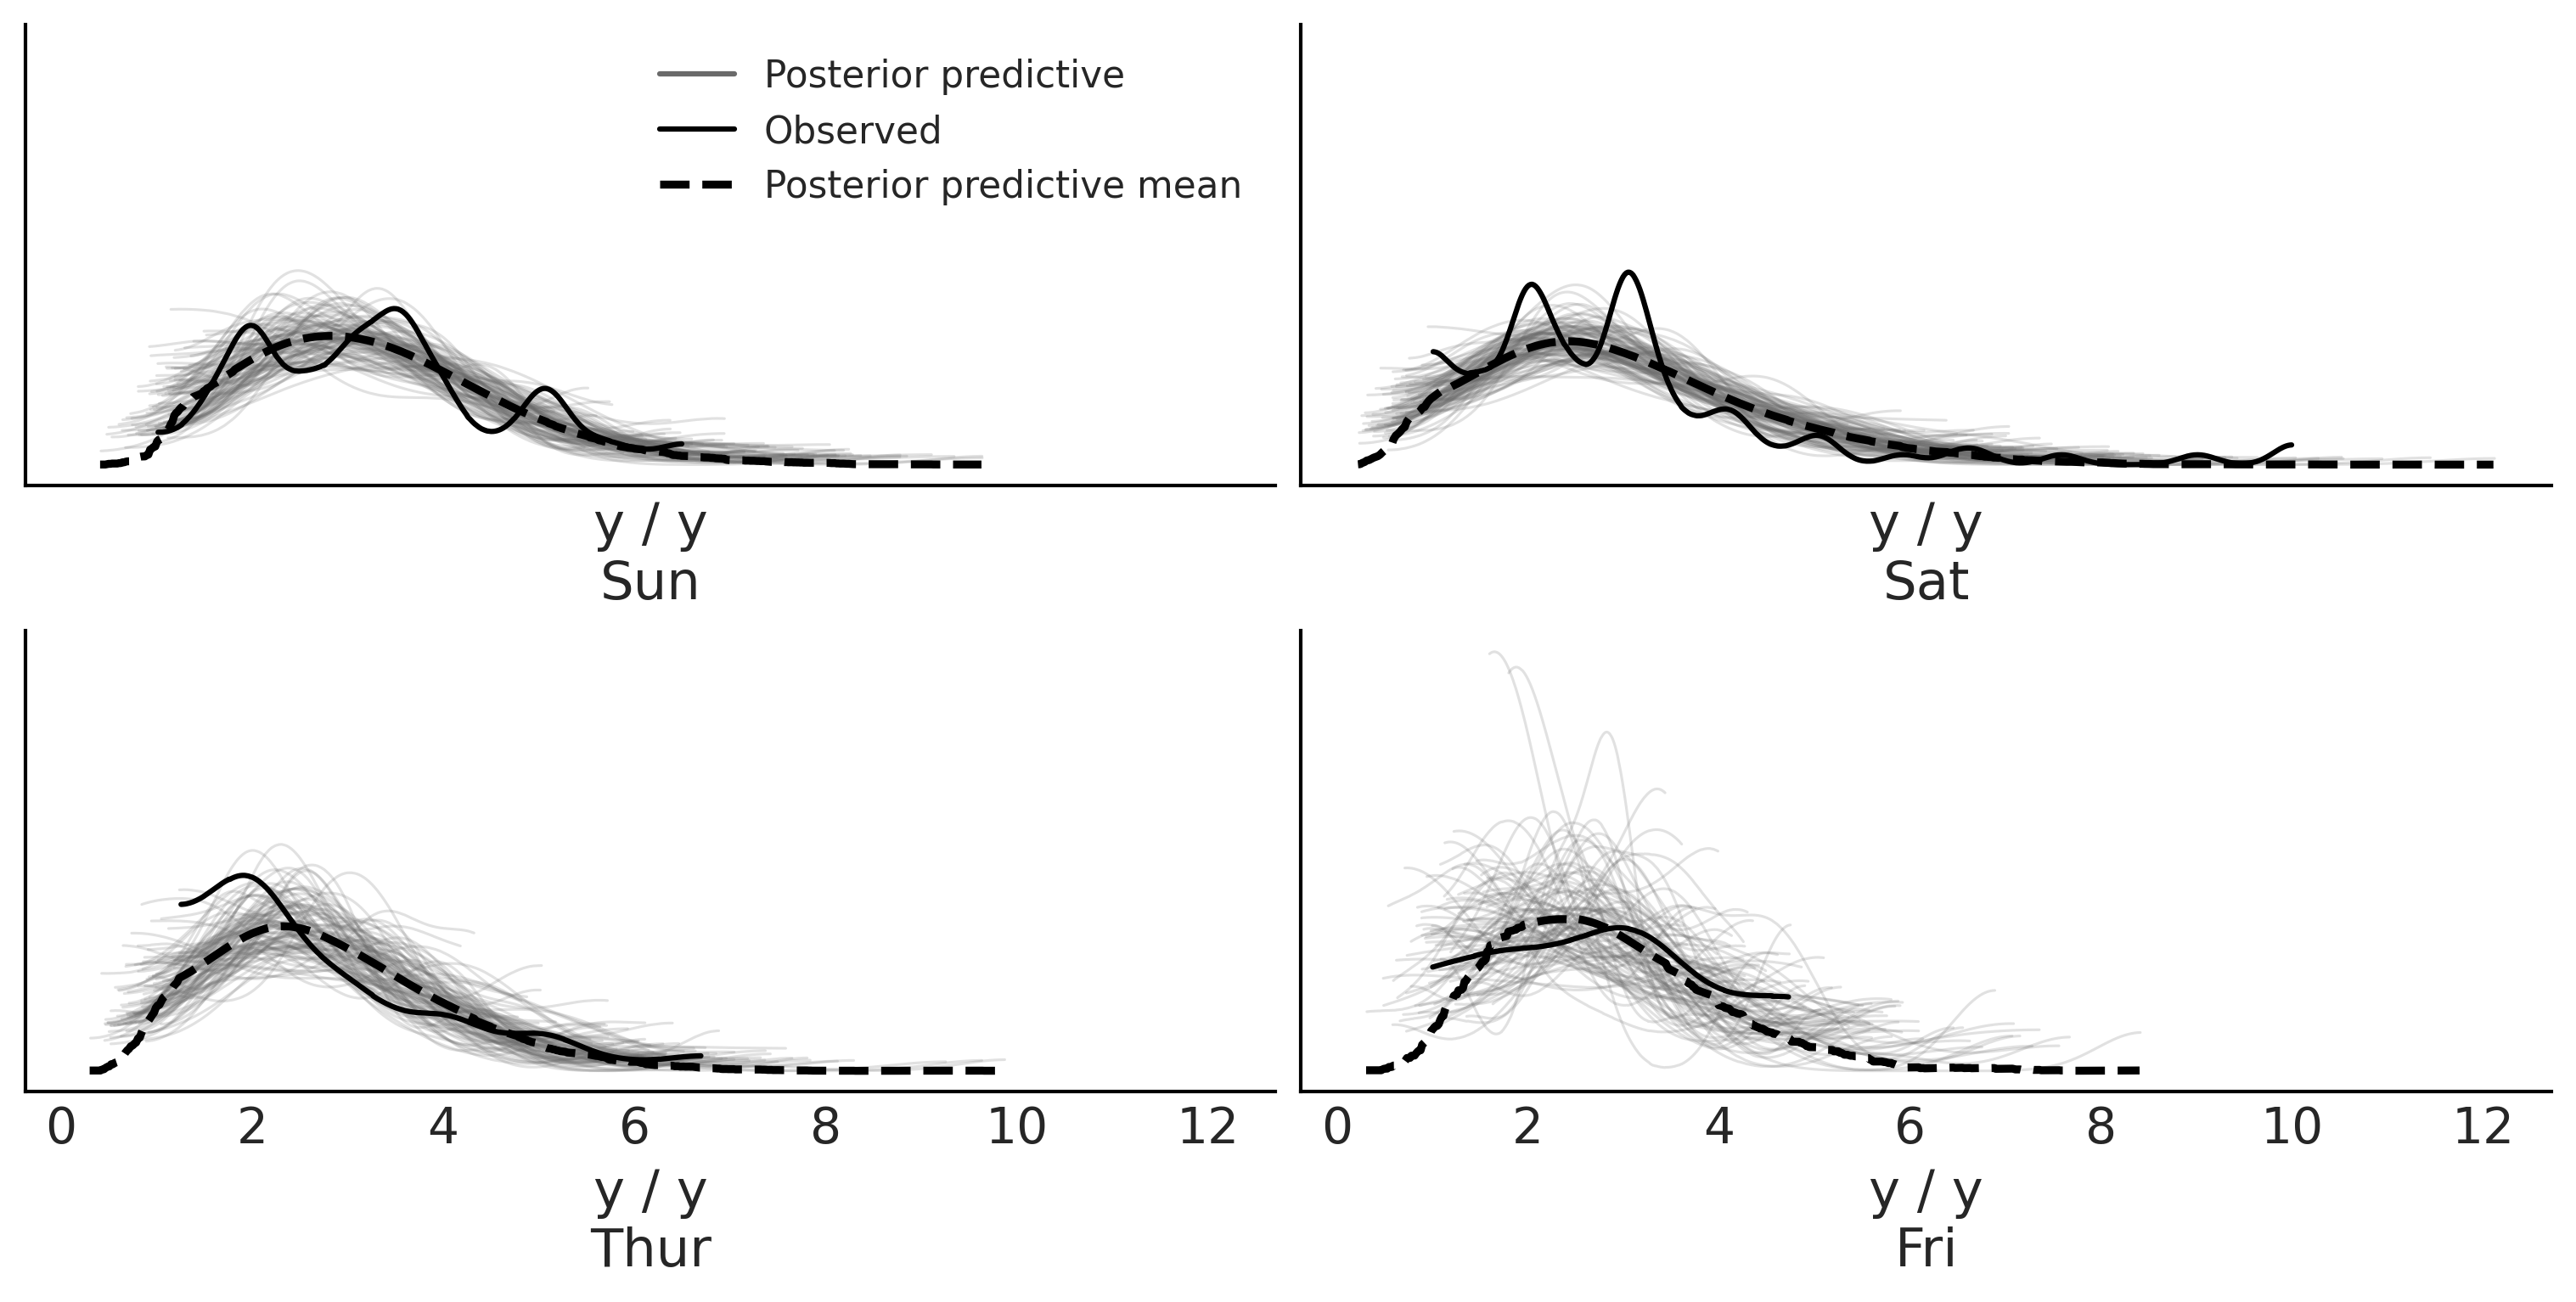

In [37]:
_, axes = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
az.plot_ppc(idata_cg, num_pp_samples=100,
            colors=["C1", "C0", "C0"],
            coords={"days_flat":[categories]}, flatten=[], ax=axes)
plt.savefig("../fig/ppc_tips.png")

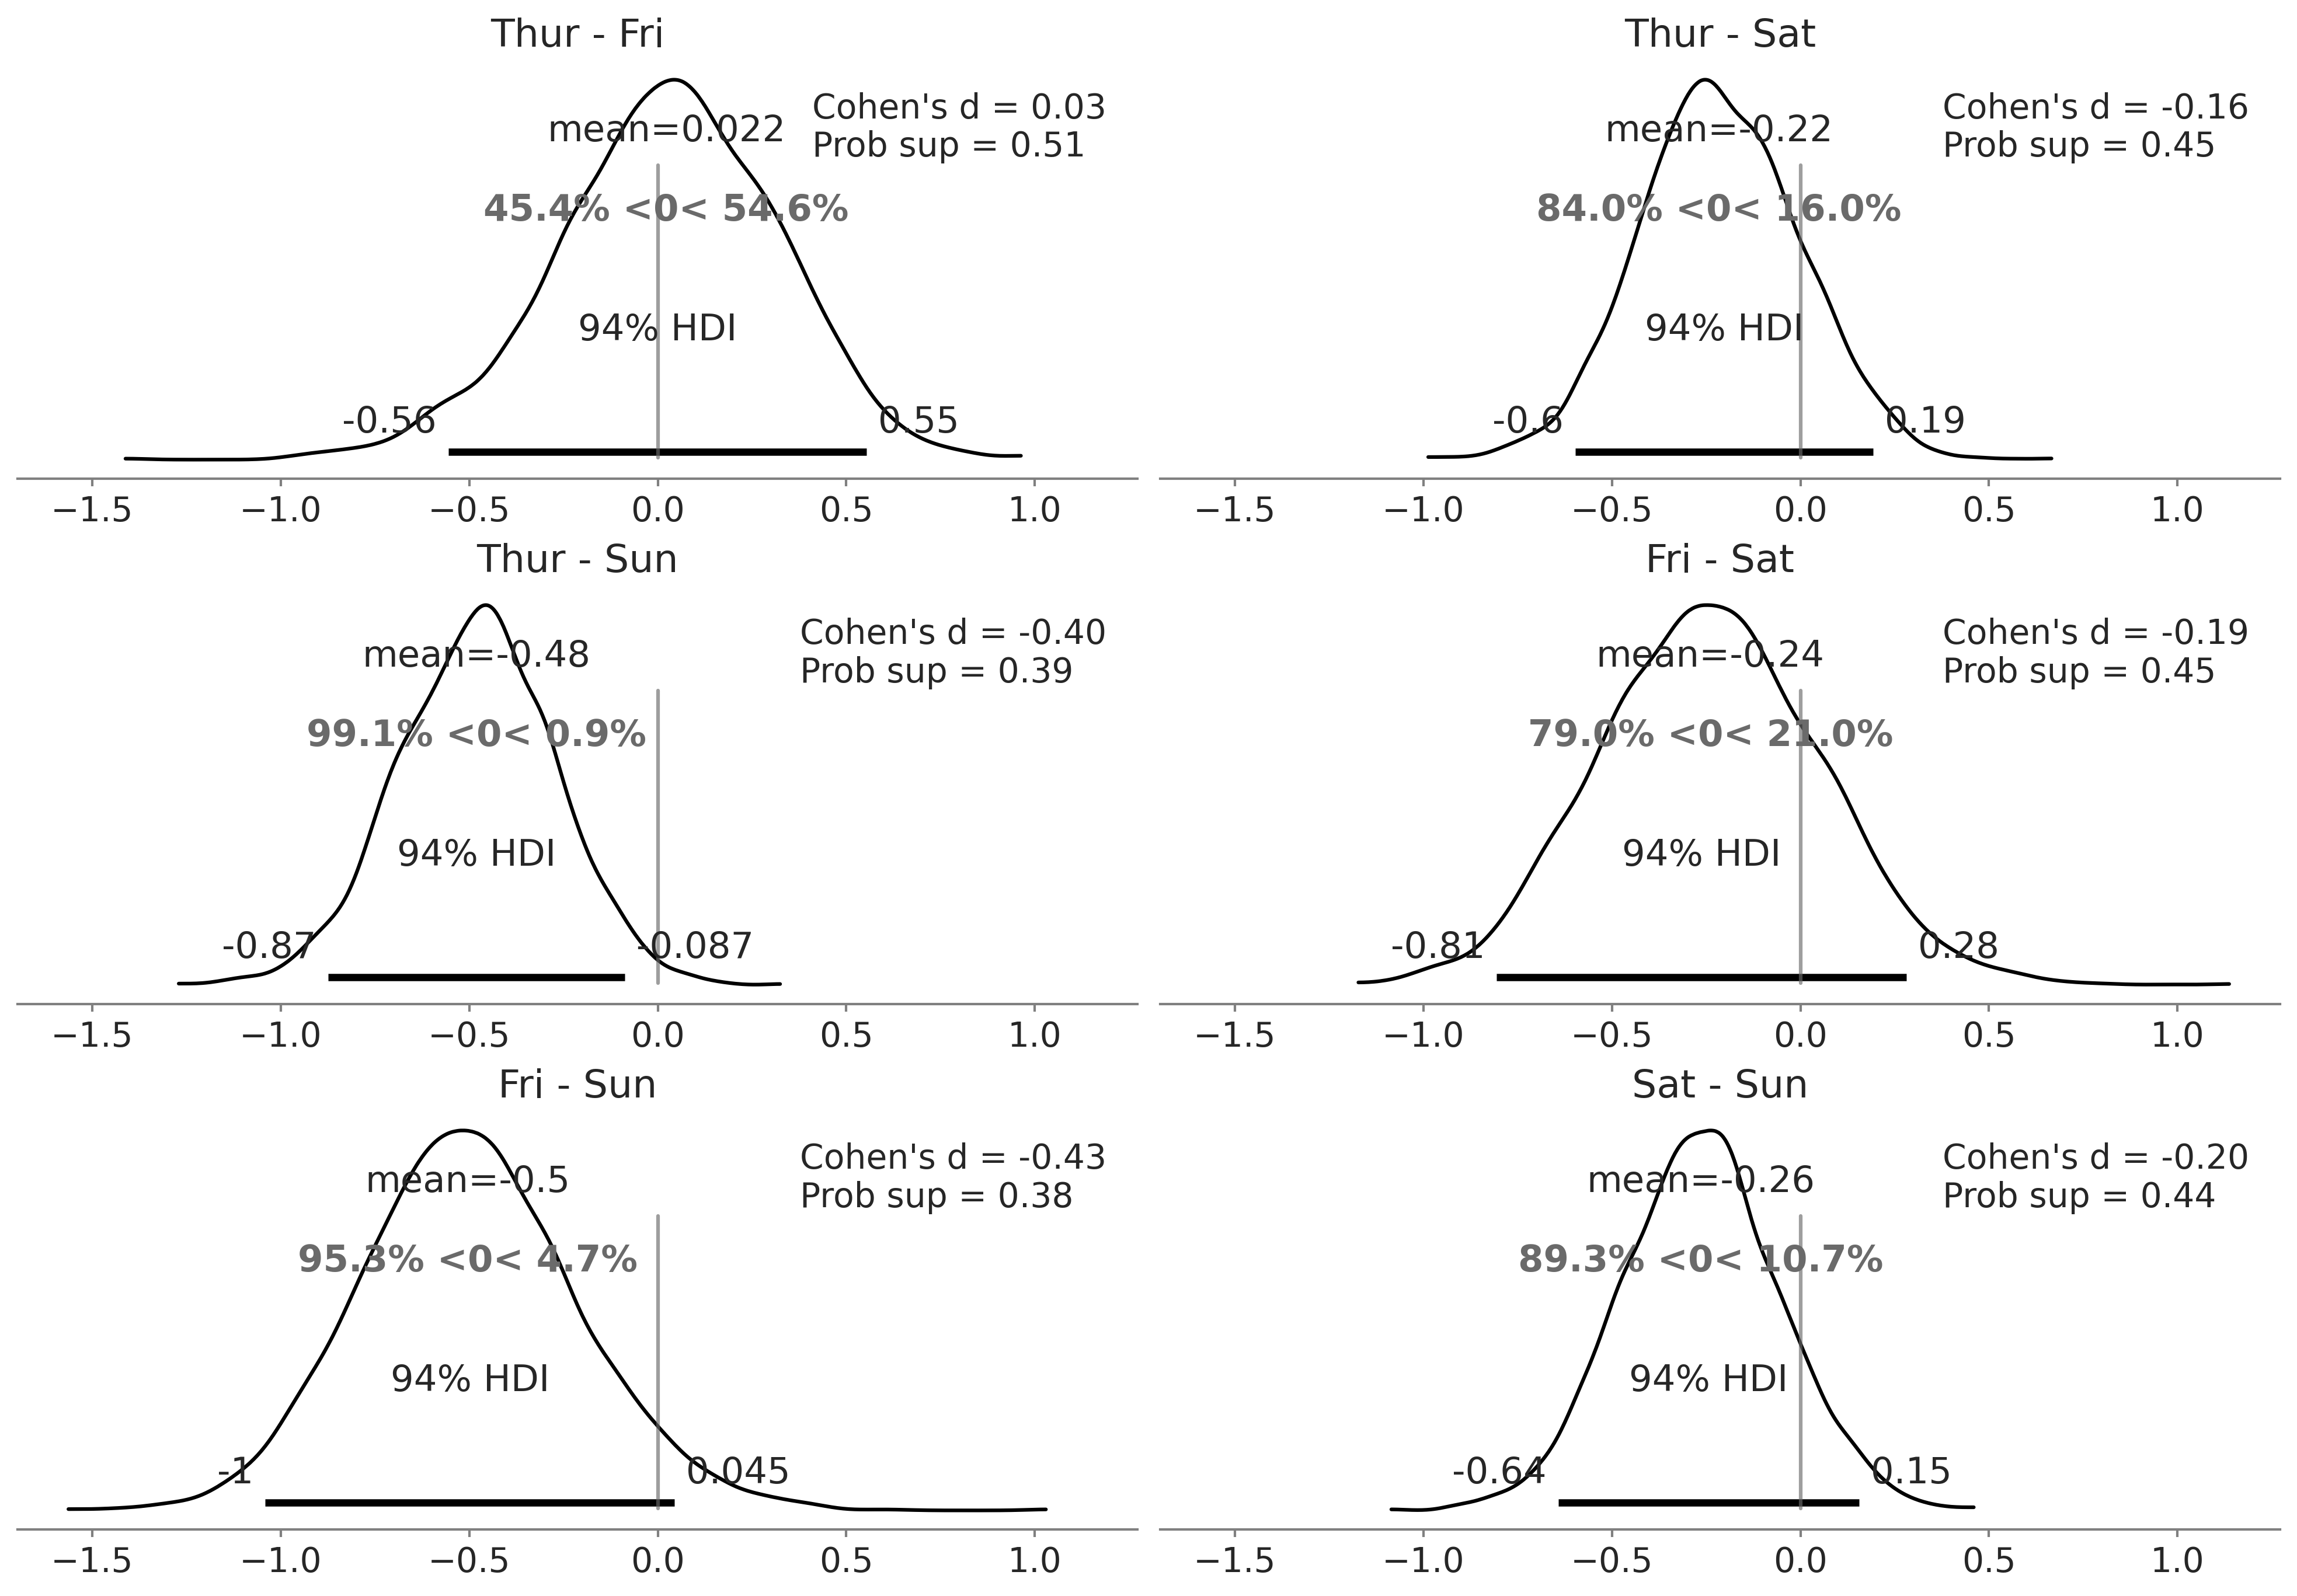

In [38]:
cg_posterior = az.extract(idata_cg)

dist = pz.Normal(0, 1)

comparisons = [(categories[i], categories[j]) for i in range(4) for j in range(i+1, 4)]

_, axes = plt.subplots(3, 2, figsize=(13, 9), sharex=True)

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["μ"].sel(days=i) - cg_posterior['μ'].sel(days=j)
    
    d_cohen = (means_diff /
               np.sqrt((cg_posterior["σ"].sel(days=i)**2 + 
                        cg_posterior["σ"].sel(days=j)**2) / 2)
              ).mean().item()
    
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend(loc=1)
plt.savefig("../fig/tips_posterior.png")